## Machinery

In [4]:
%load_ext watermark
%watermark -i -v -m -p pandas,pystan,arviz

2021-02-18T23:10:38+08:00

CPython 3.8.6
IPython 7.20.0

pandas 1.2.2
pystan 2.19.1.1
arviz 0.11.1

compiler   : GCC 9.3.0
system     : Linux
release    : 5.8.0-43-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


In [5]:
import pandas as pd
import numpy as np
from termcolor import colored

%load_ext rpy2.ipython

import isoweek

import os
import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='arviz')

In [6]:
%matplotlib inline
# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.lines import Line2D

# Parameters for seaborn plots
import seaborn as sns
clrs = sns.color_palette("Spectral", 6)
def set_plot_style(usetex=False):
    sns.set_style('white', {'axes.linewidth': 0.5})
    sns.set(style='white', font_scale=1.1,#context='paper',
            rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
                'text.usetex': usetex, 'font.family': 'serif', 'font.serif': ['Verdana'],
                'text.latex.preamble': r"\usepackage{type1cm}"}) 
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    
set_plot_style()

month_names = ["Unknown", "January", "Febuary", "March", "April", "May", "June", "July", 
               "August", "September", "October", "November", "December"]

%config InlineBackend.figure_format = 'retina'

In [7]:
import pystan
import arviz as az

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5), 
             "q25": lambda x: np.percentile(x, 25), 
             "median": lambda x: np.percentile(x, 50), 
             "q75": lambda x: np.percentile(x, 75), 
             "q97.5": lambda x: np.percentile(x, 97.5)}

def get_stats(cmdstan_data, varnames):
    # include mean and hdi
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.95).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.50).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, var_names=varnames, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

def get_stats_2d(cmdstan_data, varnames):
    # include mean and hpd
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.95).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.50).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, var_names=varnames, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else x for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25',
                        'median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

In [8]:
standistribdir = '../../../../CmdStan'
stanworkdir = '../../../NTU_Backup/mortality-US_all_states_20210204/reporting_delay-partial'
!mkdir -p {stanworkdir}

stanworkdir_independent_pooling = '../../../NTU_Backup/mortality-US_all_states_20210128/reporting_delay-unimodal'

In [9]:
import multiprocessing
from joblib import Parallel, delayed

num_cores = multiprocessing.cpu_count()
num_cores

12

# <font color="purple">Loading the data</font>

In [10]:
datadir = "../../data/mortality"
datafiles = !ls {datadir}/*csv
datafiles

['../../data/mortality/2020W34 (enddate 20200822; updated 20200902) - cdc.csv',
 '../../data/mortality/2020W35 (enddate 20200829; updated 20200909) - cdc.csv',
 '../../data/mortality/2020W37 (enddate 20200912; updated 20200922) - covdata.csv',
 '../../data/mortality/2020W38 (enddate 20200919; updated 20200929) - covdata.csv',
 '../../data/mortality/2020W39 (enddate 20200926; updated 20201006) - covdata.csv',
 '../../data/mortality/2020W40 (enddate 20201003; updated 20201015) - cdc.csv',
 '../../data/mortality/2020W41 (enddate 20201010; updated 20201022) - cdc.csv',
 '../../data/mortality/2020W42 (enddate 20201017; updated 20201029) - cdc.csv',
 '../../data/mortality/2020W43 (enddate 20201024; updated 20201103) - cdc.csv',
 '../../data/mortality/2020W44 (enddate 20201031; updated 20201110) - cdc.csv',
 '../../data/mortality/2020W45 (enddate 20201107; updated 20201119) - cdc.csv',
 '../../data/mortality/2020W46 (enddate 20201114; updated 20201126) - cdc.csv',
 '../../data/mortality/2020W

In [11]:
df = None
for datafile in datafiles:
    df_ = pd.read_csv(datafile)
    df_['source'] = datafile.split('/')[-1].split(' - ')[-1][:-4]
    df_['reporting'] = pd.to_datetime(datafile.split('updated ')[-1].split(') ')[0], format="%Y-%m-%d")
    df = df_ if df is None else df.append(df_)
df['number_of_deaths'] = df['number_of_deaths'].astype(pd.Int64Dtype())
df['week'] = ["%dW%02d"%(x,y) for x,y in zip(df['year'],df['week'])]
df['reporting_week'] = [x.strftime("%YW%V") for x in df['reporting']]
df = df.loc[:, ['jurisdiction', 'week', 'number_of_deaths', 'reporting_week']]
# removing United States
df = df.loc[lambda d: (d.jurisdiction!='United States')]
print(df['reporting_week'].unique())
df[:5]

['2020W36' '2020W37' '2020W39' '2020W40' '2020W41' '2020W42' '2020W43'
 '2020W44' '2020W45' '2020W46' '2020W47' '2020W48' '2020W49' '2020W50'
 '2020W51' '2020W52' '2020W53' '2021W01' '2021W02' '2021W03' '2021W04'
 '2021W05']


,jurisdiction,week,number_of_deaths,reporting_week
0,Alabama,2020W01,1077,2020W36
1,Alabama,2020W02,1124,2020W36
2,Alabama,2020W03,1038,2020W36
3,Alabama,2020W04,1053,2020W36
4,Alabama,2020W05,1023,2020W36


In [12]:
all_jurisdictions = df.jurisdiction.unique().astype('str')
all_jurisdictions

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'New York City',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='<U20')

In [10]:
def getData(df, jurisdictions_to_remove, weekmin):
    jurisdictions_to_keep = [x for x in all_jurisdictions if x not in jurisdictions_to_remove]
    # df with jurisdiction
    df_index_jurisdictions = pd.DataFrame({'jurisdiction': jurisdictions_to_keep}).reset_index().rename(columns={'index': 'idx_jurisdiction'})
    df_index_jurisdictions['idx_jurisdiction'] += 1
    # df with snapshots
    X = df.reporting_week.unique()
    snapshots = np.sort([x for x in X if ((int(x.split("W")[-1])>=weekmin)&(int(x.split("W")[0])==2020))|(int(x.split("W")[0])!=2020)])
    df_index_snapshots = pd.DataFrame({'reporting_week': snapshots}).sort_values('reporting_week').reset_index(drop=True).reset_index().rename(columns={'index': 'idx_snapshot'})
    df_index_snapshots['idx_snapshot'] += 1
    
    df_ = df.copy().merge(df_index_jurisdictions, on='jurisdiction', how='right')
    
    # -1 means that the number of deaths is between 1 and 9
    df_['number_of_deaths'] = [-1 if pd.isnull(x) else x for x in df_['number_of_deaths']]
    # for wide format
    # -1 means that the number of deaths is between 1 and 9
    df_['number_of_deaths'] = [-1 if pd.isnull(x) else x for x in df_['number_of_deaths']]
    df_ = df_\
        .loc[:,['idx_jurisdiction','week','number_of_deaths','reporting_week']]\
        .sort_values(['idx_jurisdiction','week','reporting_week'])\
        .merge(df_index_snapshots, on='reporting_week', how='left')
    df_['idx_snapshot'] = df_.idx_snapshot.astype(pd.Int64Dtype())
    df_ = df_.pivot_table(index=['idx_jurisdiction','idx_snapshot'], values=['number_of_deaths'], 
            columns=['week'], fill_value=0) # zeros are for both zero counts and NAs since they won't affect our fit 

    return df_, df_index_jurisdictions, df_index_snapshots

df_reporting_delay__, df_index_jurisdictions__, df_index_snapshots__ = getData(df, [], 26)
print(df_index_jurisdictions__.loc[lambda d: d.jurisdiction=='Rhode Island'])
df_reporting_delay__.loc[lambda d: d.index.get_level_values('idx_jurisdiction')==42]

    idx_jurisdiction  jurisdiction
41                42  Rhode Island


number_of_deaths                          \
week                                   2020W01 2020W02 2020W03 2020W04   
idx_jurisdiction idx_snapshot                                            
42               1                         225     201     204     199   
                 2                         225     201     204     199   
                 3                         225     201     204     199   
                 4                         225     201     204     199   
                 5                         225     201     204     199   
                 6                         225     201     204     199   
                 7                         225     201     204     199   
                 8                         225     201     204     199   
                 9                         225     201     204     199   
                 10                        225     201     204     199   
                 11                        225     201     204     199   
                 12                        225     201     204     199   
                 13                        225     201     204     199   
                 14                        225     201     204     199   
                 15                        225     201     204     199   
                 16                        225     201     204     199   
                 17                        225     201     204     199   
                 18                        225     201     204     199   
                 19                        225     201     204     199   
                 20                        225     201     204     199   
                 21                        225     201     204     199   
                 22                        225     201     204     199   

                                                                               \
week                          2020W05 2020W06 2020W07 2020W08 2020W09 2020W10   
idx_jurisdiction idx_snapshot                                                   
42               1                220     244     183     205     236     254   
                 2                220     244     183     205     236     254   
                 3                220     244     183     205     236     254   
                 4                220     244     183     206     235     254   
                 5                220     244     183     206     235     254   
                 6                220     244     183     206     235     254   
                 7                220     244     183     206     235     254   
                 8                220     244     183     206     235     254   
                 9                220     244     183     206     235     254   
                 10               220     244     183     206     235     254   
                 11               220     244     183     206     235     254   
                 12               220     244     183     206     235     254   
                 13               220     244     183     206     235     254   
                 14               220     244     183     206     235     253   
                 15               220     244     183     206     235     253   
                 16               220     244     183     206     235     253   
                 17               220     244     183     206     235     253   
                 18               220     244     183     206     235     253   
                 19               220     244     183     206     235     253   
                 20               220     244     183     206     235     253   
                 21               220     244     183     206     235     253   
                 22               220     244     183     206     235     252   

                               ...                                          \
week                           ... 2020W44 2020W45 2020W46 2020W47 2020W48 

# <font color="orange">Lognormal</font>

In [11]:
stan_code_lognormal = """
data {
    int<lower = 1> J; // number of jurisdictions
    int<lower = 1> S; // number of snapshots
    int<lower = 1> W; // max week number
    int<lower = 1> Wmax[J, S];
    int<lower = 0, upper=J*(S-1)*W> N_masked; // total number of masked records in the dataset

    int<lower = -1> deaths[J, S, W]; // deaths counts (-1 means that the count was masked by CDC)

    int<lower = 1> T[S]; // vector of a publishing week for each snapshot
}

transformed data {
    int deaths0[J, W];

    for (j in 1:J) 
        deaths0[j] = deaths[j, S];
}

parameters {
    real mu_mean_delay;
    real<lower = 0> sigma_mean_delay;
    real<lower = 0> tau_mean_delay;
    vector<lower = -mu_mean_delay/sqrt(tau_mean_delay)>[J] mean_delay_raw;
    
    real<lower = 0> sd_delay;

    real<lower = 0> nu;
    
    real<lower = 1, upper = 9> deaths_masked[N_masked];
}

transformed parameters {
    /* reparameterization */
    vector<lower = 0>[J] mean_delay = mu_mean_delay + mean_delay_raw * sqrt(tau_mean_delay);

    /* delay parameters */
    vector[J] param1_delay;
    vector<lower = 0>[J] param2_delay;

    for (j in 1:J) {
        param2_delay[j] = sqrt(log(square(sd_delay / mean_delay[j]) + 1.0));
        param1_delay[j] = log(mean_delay[j]) - square(param2_delay[j]) / 2.0; 
    }
}

model {
    /* priors */
    nu ~ gamma(2, 0.1);

    mu_mean_delay ~ normal(2.5, 5.0);
    sigma_mean_delay ~ cauchy(0, 2.5);
    tau_mean_delay ~ inv_gamma(0.5, 0.5 * square(sigma_mean_delay));
    mean_delay_raw ~ student_t(nu, 0, 1); 
    
    sd_delay ~ cauchy(0, 5.0); 

    /* deaths counts with imputations */
    matrix[S-1, W] deaths_with_imputed_j;
    int kk = 0;
    for (j in 1:J) {
        deaths_with_imputed_j = to_matrix(deaths[j, 1:S-1, 1:W]);
        for (s in 1:S-1) {
            vector[Wmax[j, s]] mu_t;
            for (w in 1:Wmax[j, s]) {
                if (deaths_with_imputed_j[s, w]==-1) {
                    kk += 1;
                    deaths_with_imputed_j[s, w] = deaths_masked[kk];
                }
                mu_t[w] = (lognormal_cdf(T[S] - w + 0.5, param1_delay[j], param2_delay[j]) - lognormal_cdf(0.5, param1_delay[j], param2_delay[j]))/ (lognormal_cdf(T[s] - w + 0.5, param1_delay[j], param2_delay[j]) - lognormal_cdf(0.5, param1_delay[j], param2_delay[j]));
            }
            target += poisson_lupmf(deaths[j, S, 1:Wmax[j, s]] | to_vector(deaths_with_imputed_j[s, 1:Wmax[j, s]]) .* mu_t + 1e-8);
        }
    }
}

generated quantities {
    real<lower = 0, upper = 1> t_score[J];
    
    for (j in 1:J)
        t_score[j] = exp(student_t_lccdf(mean_delay[j] | nu, mu_mean_delay, sigma_mean_delay));
}
"""

In [12]:
stan_code_gamma = """
data {
    int<lower = 1> J; // number of jurisdictions
    int<lower = 1> S; // number of snapshots
    int<lower = 1> W; // max week number
    int<lower = 1> Wmax[J, S];
    int<lower = 0, upper=J*(S-1)*W> N_masked; // total number of masked records in the dataset

    int<lower = -1> deaths[J, S, W]; // deaths counts (-1 means that the count was masked by CDC)

    int<lower = 1> T[S]; // vector of a publishing week for each snapshot
}

transformed data {
    int deaths0[J, W];

    for (j in 1:J) 
        deaths0[j] = deaths[j, S];
}

parameters {
    real mu_mean_delay;
    real<lower = 0> sigma_mean_delay;
    real<lower = 0> tau_mean_delay;
    vector<lower = -mu_mean_delay/sqrt(tau_mean_delay)>[J] mean_delay_raw;
    
    real<lower = 0> sd_delay;

    real<lower = 0> nu;
    
    real<lower = 1, upper = 9> deaths_masked[N_masked];
}

transformed parameters {
    /* reparameterization */
    vector<lower = 0>[J] mean_delay = mu_mean_delay + mean_delay_raw * sqrt(tau_mean_delay);

    /* delay parameters */
    vector[J] param1_delay;
    vector<lower = 0>[J] param2_delay;

    for (j in 1:J) {
        param1_delay[j] = square(mean_delay[j] / sd_delay);
        param2_delay[j] = mean_delay[j] / square(sd_delay); 
    }
}

model {
    /* priors */
    nu ~ gamma(2, 0.1);

    mu_mean_delay ~ normal(2.5, 5.0);
    sigma_mean_delay ~ cauchy(0, 2.5);
    tau_mean_delay ~ inv_gamma(0.5, 0.5 * square(sigma_mean_delay));
    mean_delay_raw ~ student_t(nu, 0, 1); 
    
    sd_delay ~ cauchy(0, 5.0); 

    /* deaths counts with imputations */
    matrix[S-1, W] deaths_with_imputed_j;
    int kk = 0;
    for (j in 1:J) {
        deaths_with_imputed_j = to_matrix(deaths[j, 1:S-1, 1:W]);
        for (s in 1:S-1) {
            vector[Wmax[j, s]] mu_t;
            for (w in 1:Wmax[j, s]) {
                if (deaths_with_imputed_j[s, w]==-1) {
                    kk += 1;
                    deaths_with_imputed_j[s, w] = deaths_masked[kk];
                }
                mu_t[w] = (gamma_cdf(T[S] - w + 0.5, param1_delay[j], param2_delay[j]) - gamma_cdf(0.5, param1_delay[j], param2_delay[j]))/ (gamma_cdf(T[s] - w + 0.5, param1_delay[j], param2_delay[j]) - gamma_cdf(0.5, param1_delay[j], param2_delay[j]));
            }
            target += poisson_lupmf(deaths[j, S, 1:Wmax[j, s]] | to_vector(deaths_with_imputed_j[s, 1:Wmax[j, s]]) .* mu_t + 1e-8);
        }
    }
}

generated quantities {
    real<lower = 0, upper = 1> t_score[J];
    
    for (j in 1:J)
        t_score[j] = exp(student_t_lccdf(mean_delay[j] | nu, mu_mean_delay, sigma_mean_delay));
}
"""

In [13]:
stan_code_ensemble = """
data {
    int<lower = 1> J; // number of jurisdictions
    int<lower = 1> S; // number of snapshots
    int<lower = 1> W; // max week number
    int<lower = 1> Wmax[J, S];
    int<lower = 0, upper=J*(S-1)*W> N_masked; // total number of masked records in the dataset

    int<lower = -1> deaths[J, S, W]; // deaths counts (-1 means that the count was masked by CDC)

    int<lower = 1> T[S]; // vector of a publishing week for each snapshot
}

transformed data {
    int deaths0[J, W];

    for (j in 1:J) 
        for (w in 1:W)
            deaths0[j, w] = deaths[j, S, w];
}

parameters {
    real mu_param1_weibull;
    real<lower = 0> sigma_param1_weibull;
    real<lower = 0> tau_param1_weibull;
    vector<lower = -mu_param1_weibull/sqrt(tau_param1_weibull)>[J] param1_weibull_raw;

    real<lower = 0> sd_delay;

    real<lower = 0> nu;
    real<lower = 1, upper = 9> deaths_masked[N_masked];
    
    simplex[3] weight; // mixing proportions
}

transformed parameters {
    /* reparameterization */
    vector<lower = 0>[J] param1_weibull = mu_param1_weibull + param1_weibull_raw * sqrt(tau_param1_weibull);

    /* delay parameters */
    vector<lower = 0>[J] mean_delay;
    vector[J] param1_delay[3];
    vector<lower = 0>[J] param2_delay[3];

    for (j in 1:J) {
        // Weibull distribution
        param1_delay[2,j] = param1_weibull[j];
        param2_delay[2,j] = sd_delay / sqrt(tgamma(1.0 + 2.0 / param1_delay[2,j]) - square(tgamma(1.0 + 1.0 / param1_delay[2,j])));
        mean_delay[j] = param2_delay[2,j] * tgamma(1.0 + 1.0 / param1_delay[2,j]);    

        // Gamma distribution
        param1_delay[1,j] = square(mean_delay[j] / sd_delay);
        param2_delay[1,j] = mean_delay[j] / square(sd_delay);

        // Lognormal distribution
        param2_delay[3,j] = sqrt(log(square(sd_delay / mean_delay[j]) + 1.0));
        param1_delay[3,j] = log(mean_delay[j]) - square(param2_delay[3,j]) / 2.0;
    }
}

model {
    /* cashing */
    vector[3] log_weight = log(weight);

    /* priors */
    nu ~ gamma(2, 0.1);
    sd_delay ~ cauchy(0, 5);

    /* closeness of the subnational means */
    mu_param1_weibull ~ normal(2.5, 5.0);
    sigma_param1_weibull ~ cauchy(0, 2.5);
    tau_param1_weibull ~ inv_gamma(0.5, 0.5 * square(sigma_param1_weibull));
    param1_weibull_raw ~ student_t(nu, 0, 1); 

    /* deaths counts with imputations */
    matrix[S-1, W] deaths_with_imputed_j;
    vector[3] lps;
    int kk = 0;
    lps = log_weight;
    for (j in 1:J) {
        deaths_with_imputed_j = to_matrix(deaths[j, 1:(S-1), 1:W]);
        for (s in 1:S-1) {
            vector[Wmax[j, s]] mu_t[3];
            for (w in 1:Wmax[j, s]) {
                if (deaths_with_imputed_j[s, w]==-1) {
                    kk += 1;
                    deaths_with_imputed_j[s, w] = deaths_masked[kk];
                }
                mu_t[1, w] = (gamma_cdf(T[S] - w + 0.5, param1_delay[1, j], param2_delay[1, j]) - gamma_cdf(0.5, param1_delay[1, j], param2_delay[1, j]))/ (gamma_cdf(T[s] - w + 0.5, param1_delay[1, j], param2_delay[1, j]) - gamma_cdf(0.5, param1_delay[1, j], param2_delay[1, j]));
                mu_t[2, w] = (weibull_cdf(T[S] - w + 0.5, param1_delay[2, j], param2_delay[2, j]) - weibull_cdf(0.5, param1_delay[2, j], param2_delay[2, j]))/ (weibull_cdf(T[s] - w + 0.5, param1_delay[2, j], param2_delay[2, j]) - weibull_cdf(0.5, param1_delay[2, j], param2_delay[2, j]));
                mu_t[3, w] = (lognormal_cdf(T[S] - w + 0.5, param1_delay[3, j], param2_delay[3, j]) - lognormal_cdf(0.5, param1_delay[3, j], param2_delay[3, j]))/ (lognormal_cdf(T[s] - w + 0.5, param1_delay[3, j], param2_delay[3, j]) - lognormal_cdf(0.5, param1_delay[3, j], param2_delay[3, j]));
            }
            for (k in 1:3)
                lps[k] += poisson_lupmf(deaths0[j, 1:Wmax[j, s]] | to_vector(deaths_with_imputed_j[s, 1:Wmax[j, s]]) .* mu_t[k] + 1e-8);
        }
    }
    target += log_sum_exp(lps);
}

generated quantities {
    vector<lower = 0, upper = 1>[J] t_score;
    
    for (j in 1:J)
        t_score[j] = exp(student_t_lccdf(param1_weibull[j] | nu, mu_param1_weibull, sigma_param1_weibull));
        
    vector<lower = 0, upper = 1>[3] q;
    {
        matrix[S-1, W] deaths_with_imputed_j;
        vector[3] lps;
        int kk = 0;
        lps = log(weight);
        for (j in 1:J) {
            deaths_with_imputed_j = to_matrix(deaths[j, 1:(S-1), 1:W]);
            for (s in 1:S-1) {
                vector[Wmax[j, s]] mu_t[3];
                for (w in 1:Wmax[j, s]) {
                    if (deaths_with_imputed_j[s, w]==-1) {
                        kk += 1;
                        deaths_with_imputed_j[s, w] = deaths_masked[kk];
                    }
                    mu_t[1, w] = (gamma_cdf(T[S] - w + 0.5, param1_delay[1, j], param2_delay[1, j]) - gamma_cdf(0.5, param1_delay[1, j], param2_delay[1, j]))/ (gamma_cdf(T[s] - w + 0.5, param1_delay[1, j], param2_delay[1, j]) - gamma_cdf(0.5, param1_delay[1, j], param2_delay[1, j]));
                    mu_t[2, w] = (weibull_cdf(T[S] - w + 0.5, param1_delay[2, j], param2_delay[2, j]) - weibull_cdf(0.5, param1_delay[2, j], param2_delay[2, j]))/ (weibull_cdf(T[s] - w + 0.5, param1_delay[2, j], param2_delay[2, j]) - weibull_cdf(0.5, param1_delay[2, j], param2_delay[2, j]));
                    mu_t[3, w] = (lognormal_cdf(T[S] - w + 0.5, param1_delay[3, j], param2_delay[3, j]) - lognormal_cdf(0.5, param1_delay[3, j], param2_delay[3, j]))/ (lognormal_cdf(T[s] - w + 0.5, param1_delay[3, j], param2_delay[3, j]) - lognormal_cdf(0.5, param1_delay[3, j], param2_delay[3, j]));
                }
                for (k in 1:3)
                    lps[k] += poisson_lpmf(deaths0[j, 1:Wmax[j, s]] | to_vector(deaths_with_imputed_j[s, 1:Wmax[j, s]]) .* mu_t[k] + 1e-8);
            }
        }
        q = exp(lps - log_sum_exp(lps));
    }
}
"""

In [14]:
stan_code_ensemble_j = """
data {
    int<lower = 1> J; // number of jurisdictions
    int<lower = 1> S; // number of snapshots
    int<lower = 1> W; // max week number
    int<lower = 1> Wmax[J, S];
    int<lower = 0, upper=J*(S-1)*W> N_masked; // total number of masked records in the dataset

    int<lower = -1> deaths[J, S, W]; // deaths counts (-1 means that the count was masked by CDC)

    int<lower = 1> T[S]; // vector of a publishing week for each snapshot
}

transformed data {
    int deaths0[J, W];

    for (j in 1:J) 
        for (w in 1:W)
            deaths0[j, w] = deaths[j, S, w];
}

parameters {
    real mu_param1_weibull;
    real<lower = 0> sigma_param1_weibull;
    real<lower = 0> tau_param1_weibull;
    vector<lower = -mu_param1_weibull/sqrt(tau_param1_weibull)>[J] param1_weibull_raw;

    real<lower = 0> sd_delay;

    real<lower = 0> nu;
    real<lower = 1, upper = 9> deaths_masked[N_masked];
    
    simplex[3] weight[J]; // mixing proportions
}

transformed parameters {
    /* reparameterization */
    vector<lower = 0>[J] param1_weibull = mu_param1_weibull + param1_weibull_raw * sqrt(tau_param1_weibull);

    /* delay parameters */
    vector<lower = 0>[J] mean_delay;
    vector[J] param1_delay[3];
    vector<lower = 0>[J] param2_delay[3];

    for (j in 1:J) {
        // Weibull distribution
        param1_delay[2,j] = param1_weibull[j];
        param2_delay[2,j] = sd_delay / sqrt(tgamma(1.0 + 2.0 / param1_delay[2,j]) - square(tgamma(1.0 + 1.0 / param1_delay[2,j])));
        mean_delay[j] = param2_delay[2,j] * tgamma(1.0 + 1.0 / param1_delay[2,j]);    

        // Gamma distribution
        param1_delay[1,j] = square(mean_delay[j] / sd_delay);
        param2_delay[1,j] = mean_delay[j] / square(sd_delay);

        // Lognormal distribution
        param2_delay[3,j] = sqrt(log(square(sd_delay / mean_delay[j]) + 1.0));
        param1_delay[3,j] = log(mean_delay[j]) - square(param2_delay[3,j]) / 2.0;
    }
}

model {
    /* cashing */
    vector[3] log_weight[J];
    for (j in 1:J)
        log_weight[j] = log(weight[j]);

    /* priors */
    nu ~ gamma(2, 0.1);
    sd_delay ~ cauchy(0, 5);

    /* closeness of the subnational means */
    mu_param1_weibull ~ normal(2.5, 5.0);
    sigma_param1_weibull ~ cauchy(0, 2.5);
    tau_param1_weibull ~ inv_gamma(0.5, 0.5 * square(sigma_param1_weibull));
    param1_weibull_raw ~ student_t(nu, 0, 1); 

    /* deaths counts with imputations */
    matrix[S-1, W] deaths_with_imputed_j;
    vector[3] lps;
    int kk = 0;
    for (j in 1:J) {
        lps = log_weight[j];
        deaths_with_imputed_j = to_matrix(deaths[j, 1:(S-1), 1:W]);
        for (s in 1:S-1) {
            vector[Wmax[j, s]] mu_t[3];
            for (w in 1:Wmax[j, s]) {
                if (deaths_with_imputed_j[s, w]==-1) {
                    kk += 1;
                    deaths_with_imputed_j[s, w] = deaths_masked[kk];
                }
                mu_t[1, w] = (gamma_cdf(T[S] - w + 0.5, param1_delay[1, j], param2_delay[1, j]) - gamma_cdf(0.5, param1_delay[1, j], param2_delay[1, j]))/ (gamma_cdf(T[s] - w + 0.5, param1_delay[1, j], param2_delay[1, j]) - gamma_cdf(0.5, param1_delay[1, j], param2_delay[1, j]));
                mu_t[2, w] = (weibull_cdf(T[S] - w + 0.5, param1_delay[2, j], param2_delay[2, j]) - weibull_cdf(0.5, param1_delay[2, j], param2_delay[2, j]))/ (weibull_cdf(T[s] - w + 0.5, param1_delay[2, j], param2_delay[2, j]) - weibull_cdf(0.5, param1_delay[2, j], param2_delay[2, j]));
                mu_t[3, w] = (lognormal_cdf(T[S] - w + 0.5, param1_delay[3, j], param2_delay[3, j]) - lognormal_cdf(0.5, param1_delay[3, j], param2_delay[3, j]))/ (lognormal_cdf(T[s] - w + 0.5, param1_delay[3, j], param2_delay[3, j]) - lognormal_cdf(0.5, param1_delay[3, j], param2_delay[3, j]));
            }
            for (k in 1:3)
                lps[k] += poisson_lupmf(deaths0[j, 1:Wmax[j, s]] | to_vector(deaths_with_imputed_j[s, 1:Wmax[j, s]]) .* mu_t[k] + 1e-8);
        }
        target += log_sum_exp(lps);
    }
}

generated quantities {
    vector<lower = 0, upper = 1>[J] t_score;
    
    for (j in 1:J)
        t_score[j] = exp(student_t_lccdf(param1_weibull[j] | nu, mu_param1_weibull, sigma_param1_weibull));
        
    vector<lower = 0, upper = 1>[3] q[J];
    {
        matrix[S-1, W] deaths_with_imputed_j;
        vector[3] lps;
        int kk = 0;
        for (j in 1:J) {
            lps = log(weight[j]);
            deaths_with_imputed_j = to_matrix(deaths[j, 1:(S-1), 1:W]);
            for (s in 1:S-1) {
                vector[Wmax[j, s]] mu_t[3];
                for (w in 1:Wmax[j, s]) {
                    if (deaths_with_imputed_j[s, w]==-1) {
                        kk += 1;
                        deaths_with_imputed_j[s, w] = deaths_masked[kk];
                    }
                    mu_t[1, w] = (gamma_cdf(T[S] - w + 0.5, param1_delay[1, j], param2_delay[1, j]) - gamma_cdf(0.5, param1_delay[1, j], param2_delay[1, j]))/ (gamma_cdf(T[s] - w + 0.5, param1_delay[1, j], param2_delay[1, j]) - gamma_cdf(0.5, param1_delay[1, j], param2_delay[1, j]));
                    mu_t[2, w] = (weibull_cdf(T[S] - w + 0.5, param1_delay[2, j], param2_delay[2, j]) - weibull_cdf(0.5, param1_delay[2, j], param2_delay[2, j]))/ (weibull_cdf(T[s] - w + 0.5, param1_delay[2, j], param2_delay[2, j]) - weibull_cdf(0.5, param1_delay[2, j], param2_delay[2, j]));
                    mu_t[3, w] = (lognormal_cdf(T[S] - w + 0.5, param1_delay[3, j], param2_delay[3, j]) - lognormal_cdf(0.5, param1_delay[3, j], param2_delay[3, j]))/ (lognormal_cdf(T[s] - w + 0.5, param1_delay[3, j], param2_delay[3, j]) - lognormal_cdf(0.5, param1_delay[3, j], param2_delay[3, j]));
                }
                for (k in 1:3)
                    lps[k] += poisson_lpmf(deaths0[j, 1:Wmax[j, s]] | to_vector(deaths_with_imputed_j[s, 1:Wmax[j, s]]) .* mu_t[k] + 1e-8);
            }
            q[j] = exp(lps - log_sum_exp(lps));
        }
    }
}
"""

In [15]:
## bash file
def bash_file_unimodal(stanscriptdir):
    return """#!/bin/bash
cwd=$(pwd)
cd """+standistribdir+"""
make -j4 """+stanscriptdir+"""/fit
cd """+stanscriptdir+"""
mkdir -p diagnostics
for i in {1..4}
do
    echo Running ${i}
    SEEDNUMBER=$((1+$i))
    ./fit \\
        method=sample num_samples=1250 num_warmup=2000 thin=1 save_warmup=0 \\
            algorithm=hmc \\
                engine=nuts \\
        random seed=${SEEDNUMBER} \\
        id=$i \\
        data file=Data.R \\
        init=Init.R \\
        output file=trace-$i.csv \\
            diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
done
echo Finished haha!
"""

In [16]:
def compile_model(distribution, jurisdictions_to_remove, filename_comment):
    # idxs_jurisdictions should start from 1 and be a range to the maximal value
    standirname = stanworkdir+'/'+distribution+'_'+str(53-len(jurisdictions_to_remove))+'_'+filename_comment
    !mkdir -p {standirname}
    
    pd.DataFrame(jurisdictions_to_remove).to_csv(standirname+"/jurisdictions_to_remove.csv")

    stanscriptdir = '../Dropbox/'+standirname[9:]

    Df_reporting_delay_, df_index_jurisdictions, df_index_snapshots = getData(df, jurisdictions_to_remove, 26)
    jurisdictions = df_index_jurisdictions.jurisdiction.values
    print(jurisdictions)
    snapshots = df_index_snapshots.reporting_week.values
    df_index_jurisdictions.to_pickle(standirname+"/idx_jurisdictions.pkl")
    df_index_snapshots.to_pickle(standirname+"/idx_snapshots.pkl")
    
    Df_reporting_delay_.to_pickle(standirname+"/df_deaths_counts.pkl")
    
    Deaths = np.zeros((len(Df_reporting_delay_.index.get_level_values('idx_jurisdiction').unique()),
                       len(Df_reporting_delay_.index.get_level_values('idx_snapshot').unique()),
                       len(Df_reporting_delay_.columns.get_level_values('week').unique())), dtype='int')

    for j in range(len(jurisdictions)):
        Deaths[j, :, :] = Df_reporting_delay_.loc[lambda d: d.index.get_level_values('idx_jurisdiction')==j+1]

    # maximal non-zero week for given jurisdiction and snapshot
    ## +1 because the index count of an array starts from 1 in Stan, but from 0 in Python
    weekmax = np.matrix([[np.max(np.nonzero(x)) + 1 for x in Deaths[j, :, :]] for j in range(len(Df_reporting_delay_.index.get_level_values('idx_jurisdiction').unique()))])
    weeks = [(int(x)-2020)*53 + int(y) for x,y in [X.split("W") for X in Df_reporting_delay_.columns.get_level_values("week")]]

    # data file
    stan_data = dict({
        'T': [(int(x)-2020)*53 + int(y) for x,y in [X.split("W") for X in df_index_snapshots.set_index('idx_snapshot')\
             .loc[Df_reporting_delay_.index.get_level_values('idx_snapshot').unique()]\
             .sort_values('reporting_week').reporting_week.values]],
        'W': len(weeks),
        'S': len(snapshots),
        'J': len(jurisdictions),
        'Wmax': weekmax,
        # observed death counts
        'deaths': Deaths,
        # number of masked deaths counts
        'N_masked': np.sum(np.transpose(Df_reporting_delay_.values)[...,:-1]==-1)
    })
    pystan.misc.stan_rdump(stan_data, standirname+'/Data.R')

    # initial values
    if (distribution=='lognormal_2'):
        stan_init = dict({
            'mu_mean_delay': 2.0, 'sigma_mean_delay': 5.0, 'nu': 2.0,
            'sd_delay': 4.0*np.ones((stan_data['J']), dtype='float'),
            'mean_delay_raw': np.ones((stan_data['J']), dtype='float')
        })
    elif (distribution=='ensemble'):
        stan_init = dict({
            'mu_param1_weibull': 2.0, 'sigma_param1_weibull': 5.0, 'nu': 5.0,
            'sd_delay': 4.0,
            'param1_weibull_raw': np.ones((stan_data['J']), dtype='float')
        })
    elif (distribution=='ensemble_j'):
        stan_init = dict({
            'mu_param1_weibull': 2.0, 'sigma_param1_weibull': 5.0, 'nu': 5.0,
            'sd_delay': 4.0,
            'param1_weibull_raw': np.ones((stan_data['J']), dtype='float')
        })
    else:
        stan_init = dict({
            'mu_mean_delay': 2.0, 'sigma_mean_delay': 5.0, 'nu': 5.0,
            'sd_delay': 4.0,
            'mean_delay_raw': np.ones((stan_data['J']), dtype='float')
        })
    pystan.misc.stan_rdump(stan_init, standirname+'/Init.R')
    stan_init;

    # stan code
    f = open(standirname+"/fit.stan", "w")
    if (distribution=='lognormal'):
        f.write(stan_code_lognormal)
    elif (distribution=='ensemble'):
        f.write(stan_code_ensemble)
    elif (distribution=='ensemble_j'):
        f.write(stan_code_ensemble)
    elif (distribution=='gamma'):
        f.write(stan_code_gamma)
    f.close()

    # bash file
    f = open(standirname+"/fit_bash.sh", "w")
    f.write(bash_file_unimodal(stanscriptdir))
    f.close()

    # compilation
    !rm -f {standirname+"/fit"}
    os.system("bash "+standirname+"/fit_bash.sh")
    
    return True

In [160]:
compile_model('ensemble', ['North Carolina'], 'NC') 

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'New York City' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


True

In [165]:
compile_model('ensemble_j', ['North Carolina'], 'NC') 

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'New York City' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


True

In [123]:
compile_model('ensemble', ['North Carolina'], 'NC_weights_fixed') 

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'New York City' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


True

In [156]:
compile_model('lognormal', ['North Carolina'], 'NC') 

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'New York City' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


True

In [140]:
compile_model('gamma', ['North Carolina'], 'NC') 

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'New York City' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Puerto Rico' 'Rhode Island'
 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont'
 'Virginia' 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


True

# 52 jurisdictions without NC + NC fitted independently

In [39]:
%%time
folder = 'lognormal_52_NC'
folder = 'ensemble_52_NC'
print(colored(folder, 'red'))
posterior_glob = !cd "{stanworkdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [stanworkdir+"/"+folder+"/"+x for x in posterior_glob])

ensemble_52_NC
CPU times: user 641 ms, sys: 312 ms, total: 953 ms
Wall time: 974 ms


In [40]:
df_index_jurisdictions = pd.read_pickle(stanworkdir+"/"+folder+"/idx_jurisdictions.pkl")

In [41]:
df_output0 = get_stats_2d(cmdstan_data, ['nu', 'q',#'mu_mean_delay', 'sigma_mean_delay', 
                                         'sd_delay', 
                                         'mean_delay', 'sd_delay', 't_score'])
df_output0[:11]

/home/aakhmetz/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/aakhmetz/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/aakhmetz/anaconda3/lib/python3.8/site-packages/arviz/stats/diagnostics.py:642: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,nu,NA,9.382,1.825,4.979,5.041,28.769,3.400,4.987,5.041,10.144,37.705,10.0,36.0,2.180000e+00
1,q,0,0.500,0.000,0.000,1.000,1.000,0.000,0.000,0.500,1.000,1.000,4.0,4.0,6.489154e+15
2,q,1,0.250,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.250,1.000,4.0,4.0,5.615760e+15
3,q,2,0.250,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.250,1.000,4.0,4.0,5.615760e+15
4,sd_delay,NA,1.640,1.355,1.355,1.572,2.076,1.356,1.493,1.572,1.702,2.078,4.0,11.0,3.370000e+00
5,mean_delay,0,2.806,2.681,2.697,2.796,3.053,2.680,2.697,2.758,2.849,3.052,5.0,28.0,2.950000e+00
6,mean_delay,1,3.332,2.797,2.795,3.583,3.978,2.799,2.877,3.243,3.765,3.986,4.0,13.0,3.400000e+00
7,mean_delay,2,2.310,2.016,2.344,2.531,2.531,2.010,2.226,2.344,2.453,2.530,4.0,12.0,3.400000e+00
8,mean_delay,3,2.446,2.149,2.490,2.646,2.646,2.139,2.387,2.490,2.591,2.645,4.0,11.0,3.280000e+00
9,mean_delay,4,2.574,2.424,2.451,2.605,2.770,2.423,2.485,2.554,2.639,2.769,5.0,29.0,2.920000e+00


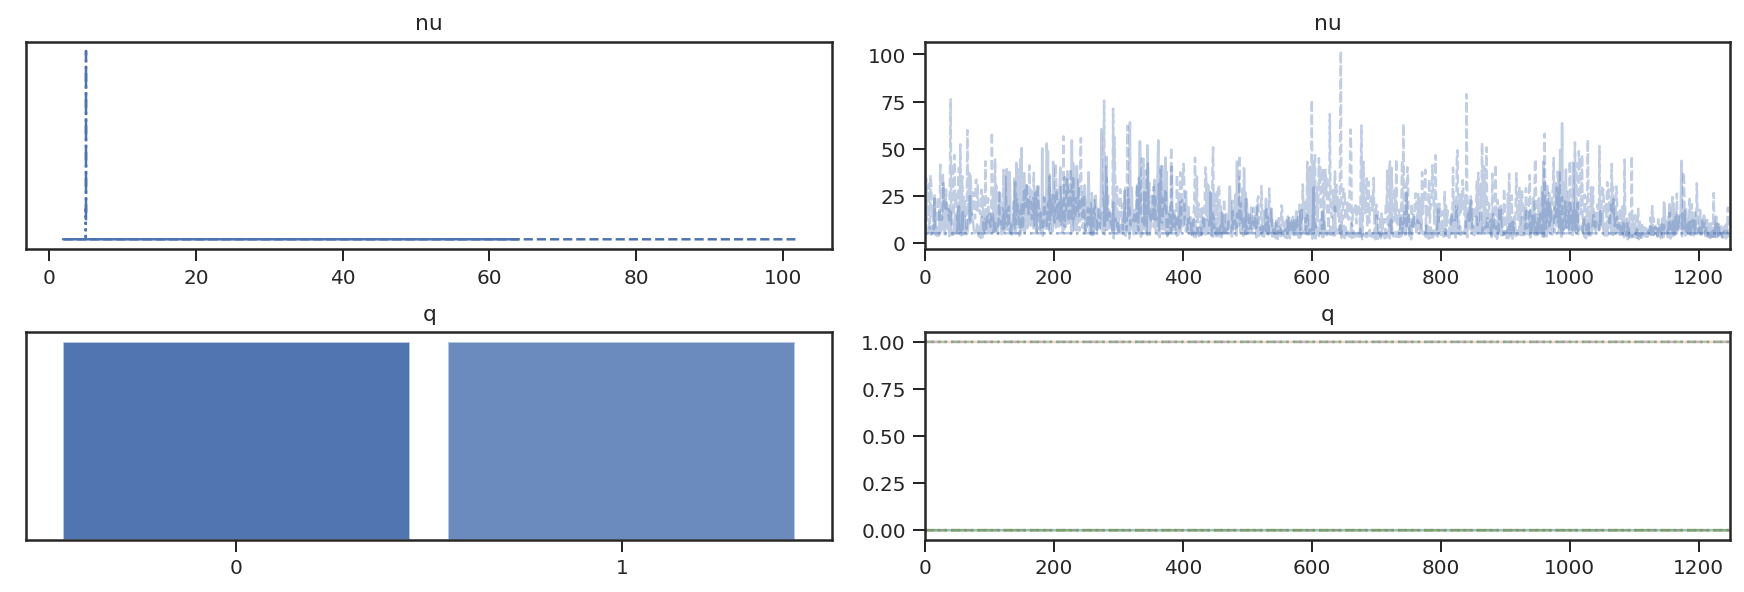

In [42]:
az.plot_trace(cmdstan_data,var_names=['nu', 'q']);

In [21]:
df_output = df_output0.loc[lambda d: d['var'].isin(['mean_delay', 't_score'])].rename(columns={'time':'idx_jurisdiction'})
df_output['idx_jurisdiction'] = [int(x)+1 for x in df_output['idx_jurisdiction']]
df_output = df_output.merge(df_index_jurisdictions, on=['idx_jurisdiction'], how='left').sort_values('idx_jurisdiction')
df_output

,var,idx_jurisdiction,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,jurisdiction
0,mean_delay,1,3.038,3.018,3.032,3.046,3.058,3.018,3.031,3.038,3.045,3.058,4974.0,4008.0,1.0,Alabama
52,t_score,1,0.349,0.074,0.362,0.462,0.506,0.034,0.303,0.382,0.426,0.486,1718.0,2194.0,1.0,Alabama
1,mean_delay,2,3.960,3.921,3.946,3.973,3.999,3.921,3.946,3.960,3.975,3.999,4877.0,4439.0,1.0,Alaska
53,t_score,2,0.129,0.000,0.000,0.124,0.296,0.000,0.038,0.124,0.204,0.316,2051.0,2243.0,1.0,Alaska
2,mean_delay,3,2.373,2.338,2.361,2.383,2.405,2.340,2.363,2.374,2.385,2.406,5063.0,3412.0,1.0,Arizona
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,mean_delay,50,5.488,5.473,5.483,5.494,5.505,5.472,5.483,5.488,5.494,5.504,4996.0,4033.0,1.0,West Virginia
102,t_score,51,0.722,0.578,0.586,0.717,1.000,0.565,0.632,0.694,0.789,0.993,2232.0,2168.0,1.0,Wisconsin
50,mean_delay,51,2.188,2.147,2.174,2.203,2.231,2.144,2.174,2.189,2.203,2.229,4959.0,3060.0,1.0,Wisconsin
51,mean_delay,52,3.041,2.978,3.023,3.066,3.107,2.975,3.020,3.042,3.064,3.105,4616.0,2505.0,1.0,Wyoming


In [22]:
df_output0_t_score = get_stats_2d(cmdstan_data,['t_score']).rename(columns={'time':'idx_jurisdiction'})
df_output0_t_score['idx_jurisdiction'] = df_output0_t_score['idx_jurisdiction'].astype('int') + 1
df_output0_t_score = df_output0_t_score.merge(df_index_jurisdictions, on=['idx_jurisdiction'], how='left').sort_values('idx_jurisdiction')
df_output0_t_score[:5]

,var,idx_jurisdiction,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,jurisdiction
0,t_score,1,0.349,0.074,0.362,0.462,0.506,0.034,0.303,0.382,0.426,0.486,1718.0,2194.0,1.0,Alabama
1,t_score,2,0.129,0.000,0.000,0.124,0.296,0.000,0.038,0.124,0.204,0.316,2051.0,2243.0,1.0,Alaska
2,t_score,3,0.657,0.503,0.543,0.645,0.933,0.520,0.580,0.627,0.705,0.964,2432.0,2310.0,1.0,Arizona
3,t_score,4,0.599,0.441,0.514,0.600,0.850,0.464,0.538,0.577,0.634,0.895,2609.0,2505.0,1.0,Arkansas
4,t_score,5,0.475,0.268,0.455,0.530,0.664,0.241,0.441,0.483,0.519,0.643,2690.0,2515.0,1.0,California


In [23]:
# identifying IQR and lower/upper 95th percentile of the t-distribution
ν = np.hstack(cmdstan_data.posterior.nu.values)
μ = np.hstack(cmdstan_data.posterior.mu_mean_delay.values)
σ = np.hstack(cmdstan_data.posterior.sigma_mean_delay.values)

import scipy.stats as ss
ppfs = np.stack([ss.t(ν[x], μ[x], σ[x]).ppf((0.025, 0.25, 0.5, 0.75, 0.975, 0.1, 0.9)) for x in range(len(ν))])
ppfs[:4]

array([[ 1.63070202,  2.29799545,  2.63847   ,  2.97894455,  3.64623798,
         1.98738057,  3.28955943],
       [ 0.87961335,  2.15434088,  2.77482   ,  3.39529912,  4.67002665,
         1.57530841,  3.97433159],
       [ 1.04119426,  2.22007773,  2.76724   ,  3.31440227,  4.49328574,
         1.6977398 ,  3.8367402 ],
       [-4.15927973,  0.5309965 ,  2.74459   ,  4.9581835 ,  9.64845973,
        -1.56543386,  7.05461386]])

In [24]:
t_ppfs = np.percentile(ppfs, q = [2.5, 50, 97.5], axis=0)
t_ppfs.round(2)

array([[-2.75,  1.  ,  2.43,  2.75,  3.07, -0.6 ,  2.9 ],
       [ 0.47,  2.01,  2.72,  3.43,  4.96,  1.34,  4.11],
       [ 2.34,  2.65,  3.  ,  4.44,  8.15,  2.5 ,  6.04]])

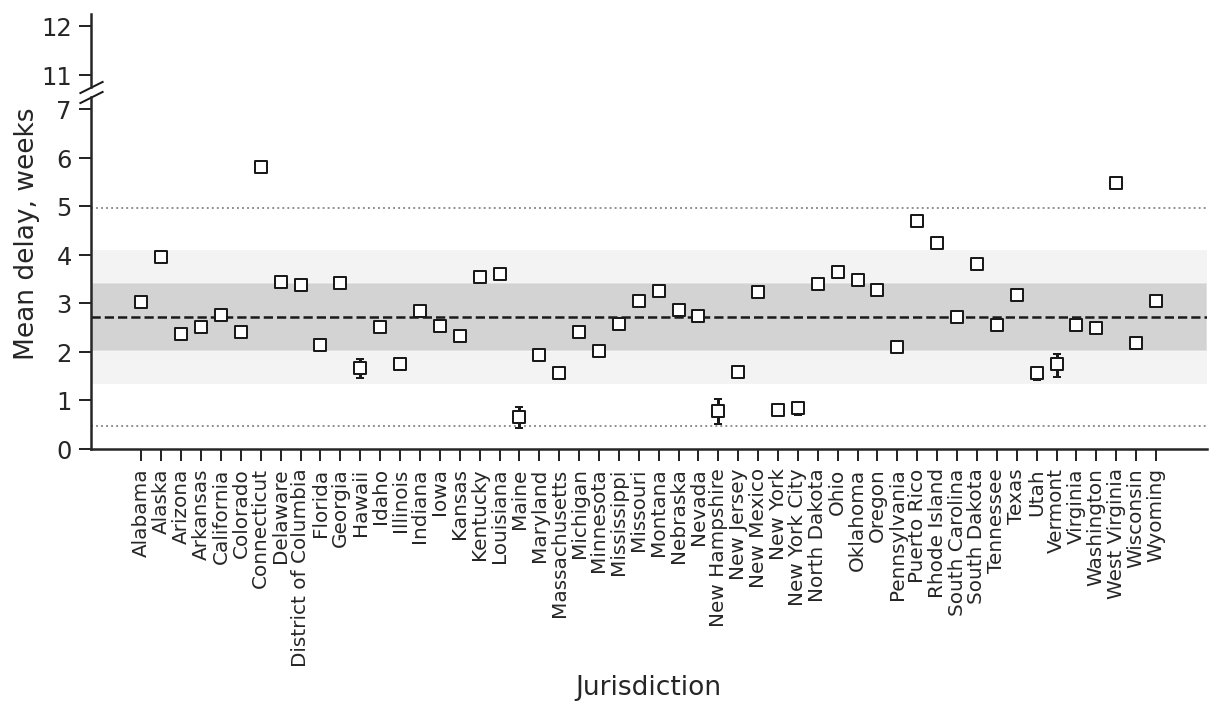

In [25]:
fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1.5/7.25, 1]})
fig.subplots_adjust(hspace=0.05)
fig.set_size_inches(10,4)

df_output_ = df_output.loc[lambda d: d['var']=='mean_delay'].sort_values('jurisdiction')
X = df_output_.jurisdiction

ax1.errorbar(X, .5*(df_output_['q25']+df_output_['q75']), .5*(df_output_['q75']-df_output_['q25']), linewidth=3.75,
            color='k', linestyle='None', zorder=-4)
ax1.errorbar(X, .5*(df_output_['q2.5']+df_output_['q97.5']), .5*(df_output_['q97.5']-df_output_['q2.5']), capsize=2,
            color='k', linestyle='None', zorder=-5)
ax1.scatter(X, df_output_['mean'], marker='s', edgecolor='k', facecolor='w', s=40);

ax2.errorbar(X, .5*(df_output_['q25']+df_output_['q75']), .5*(df_output_['q75']-df_output_['q25']), linewidth=3.75,
            color='k', linestyle='None', zorder=-4)
ax2.errorbar(X, .5*(df_output_['q2.5']+df_output_['q97.5']), .5*(df_output_['q97.5']-df_output_['q2.5']), capsize=2,
            color='k', linestyle='None', zorder=-5)
ax2.scatter(X, df_output_['mean'], marker='s', edgecolor='k', facecolor='w', s=40);

ax1.set_xlabel('Jurisdiction')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False);
plt.xticks(rotation='vertical', fontsize=10);
ax1.set_yticks(np.arange(0, 8))
ax1.set_ylim(bottom=0, top=7.25);
ax2.set_ylim(bottom=10.75, top=12.25);

ax2.spines['bottom'].set_visible(False); ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.tick_params(labeltop=False)  # don't put tick labels at the top
ax1.xaxis.tick_bottom()
ax2.xaxis.set_visible(False)

fig.text(.072, 0.5, 'Mean delay, weeks', rotation=90, va='center', ha='left')

mu_mean_delay_ = df_output0.loc[lambda d: d['var']=='mu_mean_delay','mean'].values[0]
sigma_mean_delay_ = df_output0.loc[lambda d: d['var']=='sigma_mean_delay','mean'].values[0]
ax1.axhline([t_ppfs[1, 2]], linestyle='dashed', color='k', zorder=-6, lw=1.25)
ax1.axhspan(t_ppfs[1, -2], t_ppfs[1, -1], facecolor='C7', alpha=0.1, zorder=-7)
ax1.axhspan(t_ppfs[1, 1], t_ppfs[1, 3], facecolor='C7', alpha=0.3, zorder=-7)
[ax1.axhline(t_ppfs[1, 2+2*x], linestyle='dotted', color='C7', zorder=-6, lw=.95) for x in [-1, 1]]

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax2.plot([0], transform=ax2.transAxes, **kwargs)
ax1.plot([1], transform=ax1.transAxes, **kwargs)

# fig.savefig('../../figures/draft/Fig1.pdf', format="pdf", bbox_inches='tight')

In [35]:
df_ = df_output.loc[lambda d: d['var']=='mean_delay'].loc[lambda d: (d['mean']<=t_ppfs[1, 3])]
df_.shape[0]

41

In [36]:
df_output.loc[lambda d: d['var']=='mean_delay'].loc[lambda d: (d['mean']>=t_ppfs[1, 4])]

,var,idx_jurisdiction,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,jurisdiction
6,mean_delay,7,5.817,5.801,5.812,5.823,5.833,5.801,5.812,5.817,5.823,5.833,5100.0,3800.0,1.0,Connecticut
49,mean_delay,50,5.488,5.473,5.483,5.494,5.505,5.472,5.483,5.488,5.494,5.504,4996.0,4033.0,1.0,West Virginia


In [26]:
df_output.loc[lambda d: (d['var']=='mean_delay')&(d['median']>=t_ppfs[1, -1])]

,var,idx_jurisdiction,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,jurisdiction
6,mean_delay,7,5.817,5.801,5.812,5.823,5.833,5.801,5.812,5.817,5.823,5.833,5100.0,3800.0,1.0,Connecticut
39,mean_delay,40,4.694,4.679,4.689,4.699,4.709,4.679,4.689,4.694,4.700,4.709,5415.0,4259.0,1.0,Puerto Rico
40,mean_delay,41,4.242,4.217,4.233,4.249,4.265,4.218,4.233,4.241,4.250,4.266,4785.0,4111.0,1.0,Rhode Island
49,mean_delay,50,5.488,5.473,5.483,5.494,5.505,5.472,5.483,5.488,5.494,5.504,4996.0,4033.0,1.0,West Virginia


In [27]:
df_output.loc[lambda d: d.jurisdiction.isin(df_output.loc[lambda d: (d['var']=='mean_delay')&(d['median']>=t_ppfs[1, -1])].jurisdiction.values)].loc[lambda d: d['var']=='t_score']

,var,idx_jurisdiction,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,jurisdiction
58,t_score,7,0.020,0.0,0.0,0.006,0.091,0.0,0.000,0.006,0.027,0.114,2437.0,2418.0,1.0,Connecticut
91,t_score,40,0.061,0.0,0.0,0.039,0.194,0.0,0.005,0.039,0.098,0.220,2290.0,2251.0,1.0,Puerto Rico
92,t_score,41,0.096,0.0,0.0,0.081,0.253,0.0,0.018,0.081,0.156,0.277,2160.0,2277.0,1.0,Rhode Island
101,t_score,50,0.028,0.0,0.0,0.010,0.115,0.0,0.001,0.010,0.040,0.139,2404.0,2331.0,1.0,West Virginia


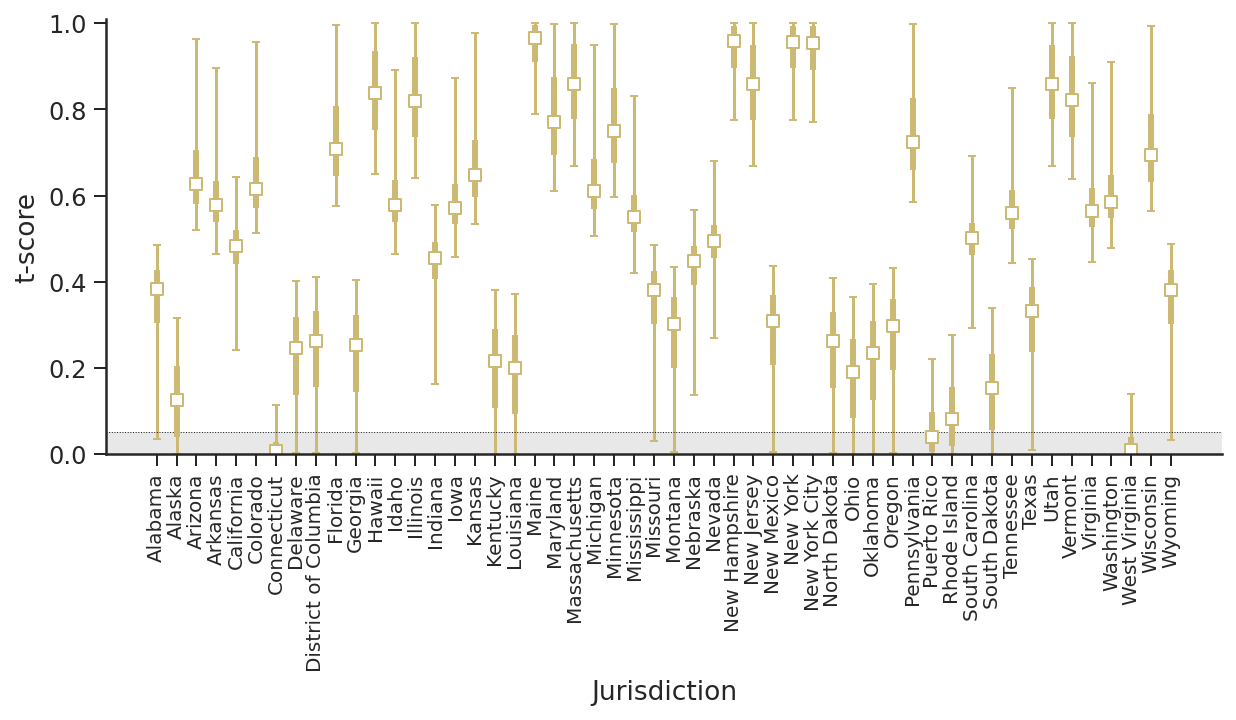

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4);

df_output_ = df_output0_t_score.copy().sort_values('jurisdiction')
X = df_output_.jurisdiction
ax.errorbar(X, .5*(df_output_['q25']+df_output_['q75']), .5*(df_output_['q75']-df_output_['q25']), linewidth=3,
            color='C8', linestyle='None', zorder=-4)
ax.errorbar(X, .5*(df_output_['q2.5']+df_output_['q97.5']), .5*(df_output_['q97.5']-df_output_['q2.5']), capsize=2,
            color='C8', linestyle='None', zorder=-5)
ax.scatter(X, df_output_['median'], marker='s', edgecolor='C8', facecolor='w', s=38);
    
[ax.axhline(y, linestyle='dotted', color='k', zorder=-5, lw=.5) for y in [0.05]]
ax.axhspan(-3.0, np.log10(0.05), facecolor='C7', alpha=0.2, zorder=-7)
    
ax.set_xlabel('Jurisdiction'); ax.set_ylabel('t-score')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
plt.xticks(rotation='vertical', fontsize=10);
ax.set_ylim(bottom=0,top=1.01)
ax.axhspan(0.0, 0.05, facecolor='C7', alpha=0.2, zorder=-7);

/home/aakhmetz/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


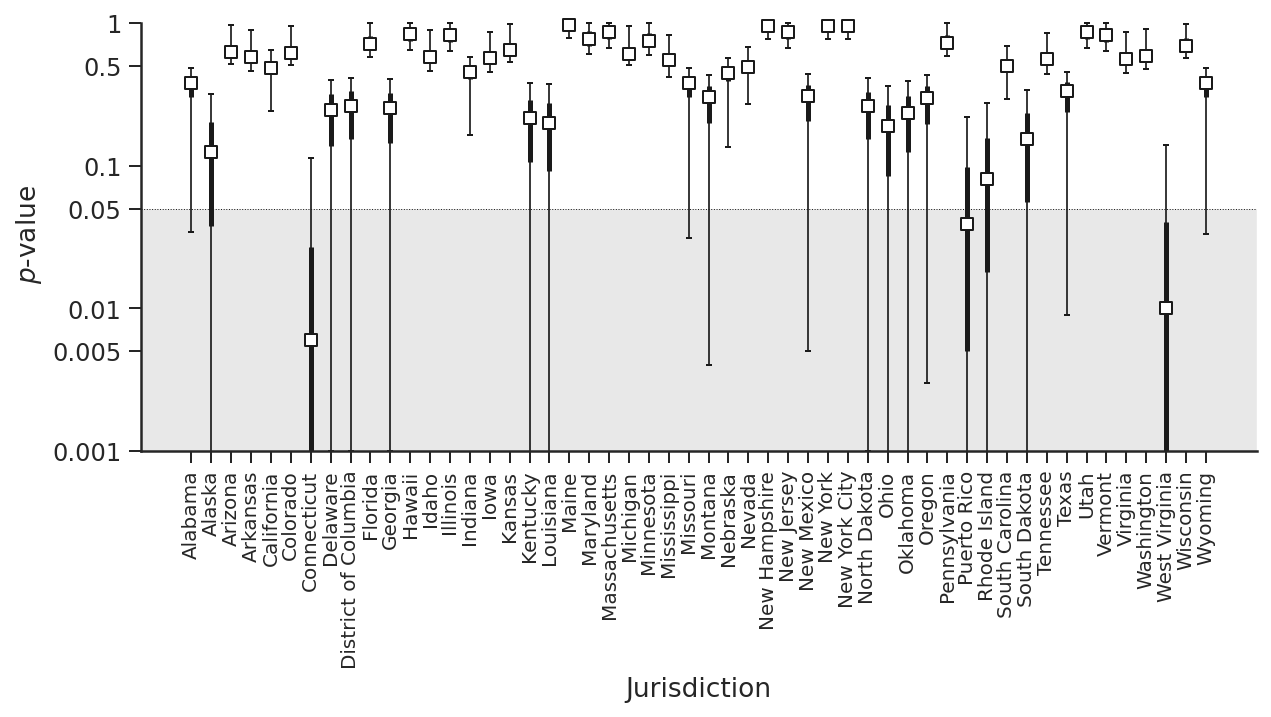

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4);

ymin = -3
df_output_ = df_output0_t_score.copy()
X = df_output_.jurisdiction

y_lower = np.array([x if np.isfinite(x) else 2*ymin for x in np.log10(df_output_['q25']).values])
y_upper = np.array([x if np.isfinite(x) else 2*ymin for x in np.log10(df_output_['q75']).values])
ax.errorbar(X, .5*(y_lower+y_upper), .5*(y_upper-y_lower), linewidth=2.5, color='k', linestyle='None', zorder=-4)

y_lower = np.array([x if np.isfinite(x) else 2*ymin for x in np.log10(df_output_['q2.5']).values])
y_upper = np.array([x if np.isfinite(x) else 2*ymin for x in np.log10(df_output_['q97.5']).values])
ax.errorbar(X, .5*(y_lower+y_upper), .5*(y_upper-y_lower), capsize=1.5, linewidth = .85, color='k', linestyle='None', zorder=-5)

ax.scatter(X, np.log10(df_output_['median']), marker='s', edgecolor='k', facecolor='w', s=40);
    
[ax.axhline(y, linestyle='dotted', color='k', zorder=-5, lw=.5) for y in np.log10([.05])]
ax.axhspan(ymin-4, np.log10(0.05), facecolor='C7', alpha=0.2, zorder=-7)
    
ax.set_xlabel('Jurisdiction'); ax.set_ylabel('$p$-value')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_bounds([ymin, 0])
plt.xticks(rotation='vertical', fontsize=10);
ax.set_ylim(bottom=ymin,top=0.05)
ytks = [.001,.005,.01,0.05,0.1,0.5,1]; ax.set_yticks(np.log10(ytks)); ax.set_yticklabels(ytks);

# fig.savefig('../../figures/draft/FigS2.pdf', format="pdf", bbox_inches='tight')

In [34]:
df_deaths = pd.read_pickle(stanworkdir+"/"+folder+"/df_deaths_counts.pkl")
df_deaths

number_of_deaths                          \
week                                   2020W01 2020W02 2020W03 2020W04   
idx_jurisdiction idx_snapshot                                            
1                1                        1077    1124    1038    1053   
                 2                        1077    1124    1038    1053   
                 3                        1077    1124    1038    1053   
                 4                        1078    1124    1039    1053   
                 5                        1080    1124    1039    1053   
...                                        ...     ...     ...     ...   
52               11                        144      81     103      96   
                 12                        144      81     103      96   
                 13                        144      81     103      96   
                 14                        144      81     103      96   
                 15                        144      81     103      96   

                                                                               \
week                          2020W05 2020W06 2020W07 2020W08 2020W09 2020W10   
idx_jurisdiction idx_snapshot                                                   
1                1               1023    1115    1091    1095    1159    1053   
                 2               1023    1115    1092    1096    1160    1053   
                 3               1024    1117    1093    1096    1161    1053   
                 4               1024    1117    1093    1096    1161    1053   
                 5               1024    1117    1093    1096    1161    1053   
...                               ...     ...     ...     ...     ...     ...   
52               11                94      97      75     101     100      80   
                 12                94      97      75     101     100      80   
                 13                94      97      75     101     100      80   
                 14                94      97      75     101     100      80   
                 15                94      97      75     101     100      80   

                               ...                                          \
week                           ... 2020W43 2020W44 2020W45 2020W46 2020W47   
idx_jurisdiction idx_snapshot  ...                                           
1                1             ...       0       0       0       0       0   
                 2             ...       0       0       0       0       0   
                 3             ...       0       0       0       0       0   
                 4             ...       0       0       0       0       0   
                 5             ...       0       0       0       0       0   
...                            ...     ...     ...     ...     ...     ...   
52               11            ...     131     112     136     123     109   
                 12            ...     131     114     136     128     122   
                 13            ...     131     114     136     129     128   
                 14            ...     131     114     136     131     129   
                 15            ...     131     114     136     131     130   

                                                                       
week                          2020W48 2020W49 2020W50 2020W51 2020W52  
idx_jurisdiction idx_snapshot                                          
1                1                  0       0       0       0       0  
                 2                  0       0       0       0       0  
                 3                  0       0       0       0       0  
                 4                  0       0       0       0       0  
                 5                  0       0       0       0       0  
...                               ...     ...     ...     ...     ...  
52               11                64       0       0       0       0  
                 12               110      54

In [35]:
df_index_snapshots = pd.read_pickle(stanworkdir+"/"+folder+"/idx_snapshots.pkl")
df_index_snapshots

,idx_snapshot,reporting_week
0,1,2020W36
1,2,2020W37
2,3,2020W42
3,4,2020W43
4,5,2020W44
5,6,2020W45
6,7,2020W46
7,8,2020W47
8,9,2020W48
9,10,2020W49


In [36]:
df_deaths0 = df_deaths.loc[lambda d: d.index.get_level_values('idx_snapshot')==max(df_index_snapshots.idx_snapshot.values)]
# reporting week
T = df_index_snapshots.loc[lambda d: d.idx_snapshot==np.max(df_index_snapshots.idx_snapshot.values)].reporting_week.values[0]
T = [(int(x)-2020)*53 + int(y) for x,y in [T.split("W")]][0]
# weeks
w = df_deaths.columns.get_level_values('week').values
w = [(int(x)-2020)*53 + int(y) for x,y in [X.split("W") for X in w]]

T, str(w)

(54,
 '[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]')

### As an example, for one particular jurisdiction

In [37]:
region = 50
μlog = np.hstack(cmdstan_data.posterior.param1_delay[:, :, region-1])
σlog = np.hstack(cmdstan_data.posterior.param2_delay[:, :, region-1])

df_deaths_ = df_deaths0.loc[lambda d: d.index.get_level_values('idx_jurisdiction')==region].values[0]
df_deaths_ = [x if x>=0 else 9 for x in df_deaths_]

In [38]:
def get_sample(params):
    μlog_, σlog_ = params
    lognorm_ = ss.lognorm(σlog_,scale=np.exp(μlog_))
    return [n + ss.nbinom(n, (lognorm_.cdf(T-w_+0.5) - lognorm_.cdf(0.5))/(1. - lognorm_.cdf(0.5))).rvs(1)[0] for n, w_ in zip(df_deaths_, w)]

In [39]:
inputs = np.transpose(np.r_[[μlog], [σlog]])
inputs

array([[1.59907 , 0.369641],
       [1.59912 , 0.369375],
       [1.60063 , 0.36872 ],
       ...,
       [1.60008 , 0.371789],
       [1.59925 , 0.370765],
       [1.60204 , 0.370206]])

In [40]:
%%time
res = Parallel(n_jobs=num_cores)(delayed(get_sample)(x) for x in inputs)

CPU times: user 3.25 s, sys: 473 ms, total: 3.73 s
Wall time: 27.3 s


In [41]:
deaths_predicted_ = np.percentile(res, q = [2.5, 25, 50, 75, 97.5], axis=0)

In [42]:
# %%time 
# res_ = np.stack([get_sample(x) for x in inputs[:1000]])
# deaths_predicted = np.percentile(res_, q = [2.5, 25, 50, 75, 97.5], axis=0)

In [43]:
deaths_predicted = np.transpose(np.r_[[w], [df_deaths_], deaths_predicted_]).astype(int)
df_deaths_predicted = pd.DataFrame(deaths_predicted)
df_deaths_predicted.columns = ['week', 'deaths', 'q2.5', 'q25', 'median', 'q75', 'q97.5']
df_deaths_predicted['iso_week'] = [str(2020 + w // 54) + "W" + str(w % 54) for w in df_deaths_predicted['week']]
df_deaths_predicted['date'] = [isoweek.Week(2020 + w // 54, w % 54).monday() for w in df_deaths_predicted['week']]
df_deaths_predicted['x_day'] = (pd.to_datetime(df_deaths_predicted['date']) - pd.Timestamp('20200101')).dt.days
df_deaths_predicted['idx_jurisdiction'] = region
df_deaths_predicted['jurisdiction'] = df_index_jurisdictions.loc[lambda d: d.idx_jurisdiction==region, 'jurisdiction'].values[0]
df_deaths_predicted[:5]

,week,deaths,q2.5,q25,median,q75,q97.5,iso_week,date,x_day,idx_jurisdiction,jurisdiction
0,1,473,473,473,473,473,473,2020W1,2019-12-30,-2,50,West Virginia
1,2,494,494,494,494,494,494,2020W2,2020-01-06,5,50,West Virginia
2,3,519,519,519,519,519,519,2020W3,2020-01-13,12,50,West Virginia
3,4,440,440,440,440,440,440,2020W4,2020-01-20,19,50,West Virginia
4,5,480,480,480,480,480,480,2020W5,2020-01-27,26,50,West Virginia


### For all jurisdictions

In [64]:
def get_df_death_counts(region):
    μlog = np.hstack(cmdstan_data.posterior.param1_delay[:, :, region-1])
    σlog = np.hstack(cmdstan_data.posterior.param2_delay[:, :, region-1])
    inputs = np.transpose(np.r_[[μlog], [σlog]])

    df_deaths_ = df_deaths0.loc[lambda d: d.index.get_level_values('idx_jurisdiction')==region].values[0]
    df_deaths_ = [x if x>=0 else 9 for x in df_deaths_]
    
    def get_sample(params):
        μlog_, σlog_ = params
        lognorm_ = ss.lognorm(σlog_,scale=np.exp(μlog_))
        return [n + ss.nbinom(n, (lognorm_.cdf(T-w_+0.5) - lognorm_.cdf(0.5))/(1. - lognorm_.cdf(0.5))).rvs(1)[0] for n, w_ in zip(df_deaths_, w)]
    
    res = Parallel(n_jobs=num_cores)(delayed(get_sample)(x) for x in inputs[:100])
    
    deaths_predicted_ = np.percentile(res, q = [2.5, 25, 50, 75, 97.5], axis=0)
    
    deaths_predicted = np.transpose(np.r_[[w], [df_deaths_], deaths_predicted_]).astype(int)
    
    ## output
    df_deaths_predicted = pd.DataFrame(deaths_predicted)
    df_deaths_predicted.columns = ['week', 'deaths', 'q2.5', 'q25', 'median', 'q75', 'q97.5']
    df_deaths_predicted['iso_week'] = [str(2020 + w // 54) + "W" + str(w % 54) for w in df_deaths_predicted['week']]
    df_deaths_predicted['date'] = [isoweek.Week(2020 + w // 54, w % 54).monday() for w in df_deaths_predicted['week']]
    df_deaths_predicted['x_day'] = (pd.to_datetime(df_deaths_predicted['date']) - pd.Timestamp('20200101')).dt.days
    df_deaths_predicted['idx_jurisdiction'] = region
    df_deaths_predicted['jurisdiction'] = df_index_jurisdictions.loc[lambda d: d.idx_jurisdiction==region, 'jurisdiction'].values[0]

    return df_deaths_predicted

In [65]:
%%time
df_deaths_predicted = None
for region in np.arange(1, 53)[::-1]:
    print(colored(df_index_jurisdictions.loc[lambda d: d.idx_jurisdiction==region, 'jurisdiction'].values[0], 'red'))
    df_deaths_predicted_ = get_df_death_counts(region)
    df_deaths_predicted = df_deaths_predicted_ if df_deaths_predicted is None else df_deaths_predicted.append(df_deaths_predicted_)
df_deaths_predicted[:5]

Wyoming
Wisconsin
West Virginia
Washington
Virginia
Vermont
Utah
Texas
Tennessee
South Dakota
South Carolina
Rhode Island
Puerto Rico
Pennsylvania
Oregon
Oklahoma
Ohio
North Dakota
New York City
New York
New Mexico
New Jersey
New Hampshire
Nevada
Nebraska
Montana
Missouri
Mississippi
Minnesota
Michigan
Massachusetts
Maryland
Maine
Louisiana
Kentucky
Kansas
Iowa
Indiana
Illinois
Idaho
Hawaii
Georgia
Florida
District of Columbia
Delaware
Connecticut
Colorado
California
Arkansas
Arizona
Alaska
Alabama
CPU times: user 7.8 s, sys: 272 ms, total: 8.07 s
Wall time: 30.1 s


,week,deaths,q2.5,q25,median,q75,q97.5,iso_week,date,x_day,idx_jurisdiction,jurisdiction
0,1,144,144,144,144,144,144,2020W1,2019-12-30,-2,52,Wyoming
1,2,81,81,81,81,81,81,2020W2,2020-01-06,5,52,Wyoming
2,3,103,103,103,103,103,103,2020W3,2020-01-13,12,52,Wyoming
3,4,96,96,96,96,96,96,2020W4,2020-01-20,19,52,Wyoming
4,5,94,94,94,94,94,94,2020W5,2020-01-27,26,52,Wyoming


In [45]:
# df_deaths_predicted.to_pickle("df_deaths_predicted.pkl")

### Historical death counts

In [56]:
df_hist = pd.read_pickle("df_historical_deaths.pkl")
df_hist[:5]

,jurisdiction,year,week,number_of_deaths,idx_jurisdiction
0,Alabama,2014,1,355,1
1,Alabama,2014,2,872,1
2,Alabama,2014,3,1044,1
3,Alabama,2014,4,1022,1
4,Alabama,2014,5,1040,1


In [57]:
df_hist = df_hist.drop('idx_jurisdiction',1).merge(df_index_jurisdictions, on='jurisdiction', how='right')
df_hist[:5]

,jurisdiction,year,week,number_of_deaths,idx_jurisdiction
0,Alabama,2014,1,355,1
1,Alabama,2014,2,872,1
2,Alabama,2014,3,1044,1
3,Alabama,2014,4,1022,1
4,Alabama,2014,5,1040,1


In [59]:
df_hist['date'] = [isoweek.Week(y, w).monday() for y, w in zip(df_hist['year'].astype(int), df_hist['week'].astype(int))]
df_hist['x_day'] = [pd.to_datetime(x1) - pd.Timestamp('%d0101'%x2) for x1,x2 in zip(df_hist['date'], df_hist['year'])]
df_hist['x_day'] = df_hist['x_day'].dt.days
df_hist[:5]

,jurisdiction,year,week,number_of_deaths,idx_jurisdiction,date,x_day
0,Alabama,2014,1,355,1,2013-12-30,-2
1,Alabama,2014,2,872,1,2014-01-06,5
2,Alabama,2014,3,1044,1,2014-01-13,12
3,Alabama,2014,4,1022,1,2014-01-20,19
4,Alabama,2014,5,1040,1,2014-01-27,26


### Historical data

In [73]:
%%time
stanworkdir_historical = '../../../NTU_Backup/mortality-US_all_states_20210107/historical'
folder_historical = 'baseline_final'
print(colored(folder_historical, 'red'))
posterior_glob_historical = !cd "{stanworkdir_historical}/{folder_historical}"; ls trace-*
cmdstan_data_historical = az.from_cmdstan(posterior = [stanworkdir_historical+"/"+folder_historical+"/"+x for x in posterior_glob_historical])

baseline_final
CPU times: user 7.53 s, sys: 364 ms, total: 7.89 s
Wall time: 7.9 s


In [74]:
%%time
df_output_historical_ = get_stats_2d(cmdstan_data_historical, ['deaths_baseline'])
df_output_historical_[:11]

CPU times: user 48.2 s, sys: 30.9 ms, total: 48.2 s
Wall time: 48.2 s


,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat
0,deaths_baseline,"0,0",1094.522,1018.0,1067.0,1113.0,1159.0,1024.975,1071.0,1094.0,1117.0,1166.0,9402.0,10011.0,1.0
1,deaths_baseline,"0,1",1091.296,1016.0,1066.0,1113.0,1155.0,1022.000,1067.0,1091.0,1115.0,1161.0,10071.0,9396.0,1.0
2,deaths_baseline,"0,2",1087.046,1014.0,1062.0,1109.0,1153.0,1018.000,1063.0,1087.0,1111.0,1158.0,9757.0,9858.0,1.0
3,deaths_baseline,"0,3",1083.075,1015.0,1060.0,1106.0,1151.0,1015.000,1060.0,1083.0,1107.0,1152.0,10128.0,9898.0,1.0
4,deaths_baseline,"0,4",1077.774,1009.0,1049.0,1096.0,1143.0,1011.000,1054.0,1077.5,1101.0,1145.0,10058.0,9323.0,1.0
5,deaths_baseline,"0,5",1073.302,1007.0,1043.0,1089.0,1141.0,1007.000,1050.0,1072.0,1096.0,1142.0,9878.0,9896.0,1.0
6,deaths_baseline,"0,6",1068.095,999.0,1039.0,1086.0,1136.0,1000.000,1044.0,1068.0,1092.0,1138.0,9644.0,9615.0,1.0
7,deaths_baseline,"0,7",1062.462,993.0,1036.0,1082.0,1128.0,996.000,1039.0,1062.0,1086.0,1131.0,9424.0,9056.0,1.0
8,deaths_baseline,"0,8",1055.916,987.0,1030.0,1076.0,1124.0,986.000,1033.0,1056.0,1079.0,1124.0,9531.0,9463.0,1.0
9,deaths_baseline,"0,9",1048.939,980.0,1019.0,1065.0,1114.0,982.000,1026.0,1049.0,1072.0,1116.0,8872.0,9058.0,1.0


In [76]:
df_index_jurisdictions_historical = pd.read_pickle(stanworkdir_historical+"/"+folder_historical+"/idx_jurisdictions.pkl")

In [77]:
df_output_historical = df_output_historical_.copy()
df_output_historical[['idx_jurisdiction', 'week']] = df_output_historical['time'].str.split(',',expand=True)
df_output_historical['idx_jurisdiction'] = df_output_historical['idx_jurisdiction'].astype('int') + 1
df_output_historical['week'] = df_output_historical['week'].astype('int') + 1
df_output_historical = df_output_historical.merge(df_index_jurisdictions_historical, on='idx_jurisdiction', how='left')
df_output_historical = df_output_historical.drop('idx_jurisdiction', 1).merge(df_index_jurisdictions, on='jurisdiction', how='left')
df_output_historical

,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,week,jurisdiction,idx_jurisdiction
0,deaths_baseline,"0,0",1094.522,1018.0,1067.0,1113.0,1159.0,1024.975,1071.0,1094.0,1117.0,1166.0,9402.0,10011.0,1.0,1,Alabama,1
1,deaths_baseline,"0,1",1091.296,1016.0,1066.0,1113.0,1155.0,1022.000,1067.0,1091.0,1115.0,1161.0,10071.0,9396.0,1.0,2,Alabama,1
2,deaths_baseline,"0,2",1087.046,1014.0,1062.0,1109.0,1153.0,1018.000,1063.0,1087.0,1111.0,1158.0,9757.0,9858.0,1.0,3,Alabama,1
3,deaths_baseline,"0,3",1083.075,1015.0,1060.0,1106.0,1151.0,1015.000,1060.0,1083.0,1107.0,1152.0,10128.0,9898.0,1.0,4,Alabama,1
4,deaths_baseline,"0,4",1077.774,1009.0,1049.0,1096.0,1143.0,1011.000,1054.0,1077.5,1101.0,1145.0,10058.0,9323.0,1.0,5,Alabama,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2804,deaths_baseline,"52,48",1106.750,1040.0,1084.0,1131.0,1178.0,1037.000,1083.0,1106.0,1131.0,1177.0,9518.0,9819.0,1.0,49,Wisconsin,51
2805,deaths_baseline,"52,49",1112.783,1044.0,1081.0,1130.0,1183.0,1043.000,1088.0,1113.0,1137.0,1183.0,9842.0,9705.0,1.0,50,Wisconsin,51
2806,deaths_baseline,"52,50",1117.078,1045.0,1094.0,1142.0,1185.0,1047.000,1092.0,1117.0,1141.0,1188.0,8610.0,9710.0,1.0,51,Wisconsin,51
2807,deaths_baseline,"52,51",1120.681,1044.0,1087.0,1136.0,1189.0,1049.000,1096.0,1120.0,1145.0,1195.0,8535.0,9074.0,1.0,52,Wisconsin,51


In [78]:
df_output_historical['date'] = [isoweek.Week(2020, w).monday() for w in df_output_historical['week'].astype(int)]
df_output_historical['x_day'] = [pd.to_datetime(x1) - pd.Timestamp('20200101') for x1 in df_output_historical['date']]
df_output_historical['x_day'] = df_output_historical['x_day'].dt.days
df_output_historical[:5]

,var,time,mean,hdi2.5,hdi25,hdi75,hdi97.5,q2.5,q25,median,q75,q97.5,ess_bulk,ess_tail,r_hat,week,jurisdiction,idx_jurisdiction,date,x_day
0,deaths_baseline,"0,0",1094.522,1018.0,1067.0,1113.0,1159.0,1024.975,1071.0,1094.0,1117.0,1166.0,9402.0,10011.0,1.0,1,Alabama,1,2019-12-30,-2
1,deaths_baseline,"0,1",1091.296,1016.0,1066.0,1113.0,1155.0,1022.000,1067.0,1091.0,1115.0,1161.0,10071.0,9396.0,1.0,2,Alabama,1,2020-01-06,5
2,deaths_baseline,"0,2",1087.046,1014.0,1062.0,1109.0,1153.0,1018.000,1063.0,1087.0,1111.0,1158.0,9757.0,9858.0,1.0,3,Alabama,1,2020-01-13,12
3,deaths_baseline,"0,3",1083.075,1015.0,1060.0,1106.0,1151.0,1015.000,1060.0,1083.0,1107.0,1152.0,10128.0,9898.0,1.0,4,Alabama,1,2020-01-20,19
4,deaths_baseline,"0,4",1077.774,1009.0,1049.0,1096.0,1143.0,1011.000,1054.0,1077.5,1101.0,1145.0,10058.0,9323.0,1.0,5,Alabama,1,2020-01-27,26


### Plots

In [79]:
## xticks
xstep = 4
x_ = np.r_[12 - np.arange(0,12,xstep), [1]]
xtks = ['2020%02d01'%x for x in x_]
xtks = [(pd.Timestamp(x) - pd.Timestamp('20200101')).days for x in xtks]
xtk_labels = [month_names[x][:3] for x in x_]
xtks, xtk_labels

([335, 213, 91, 0], ['Dec', 'Aug', 'Apr', 'Jan'])

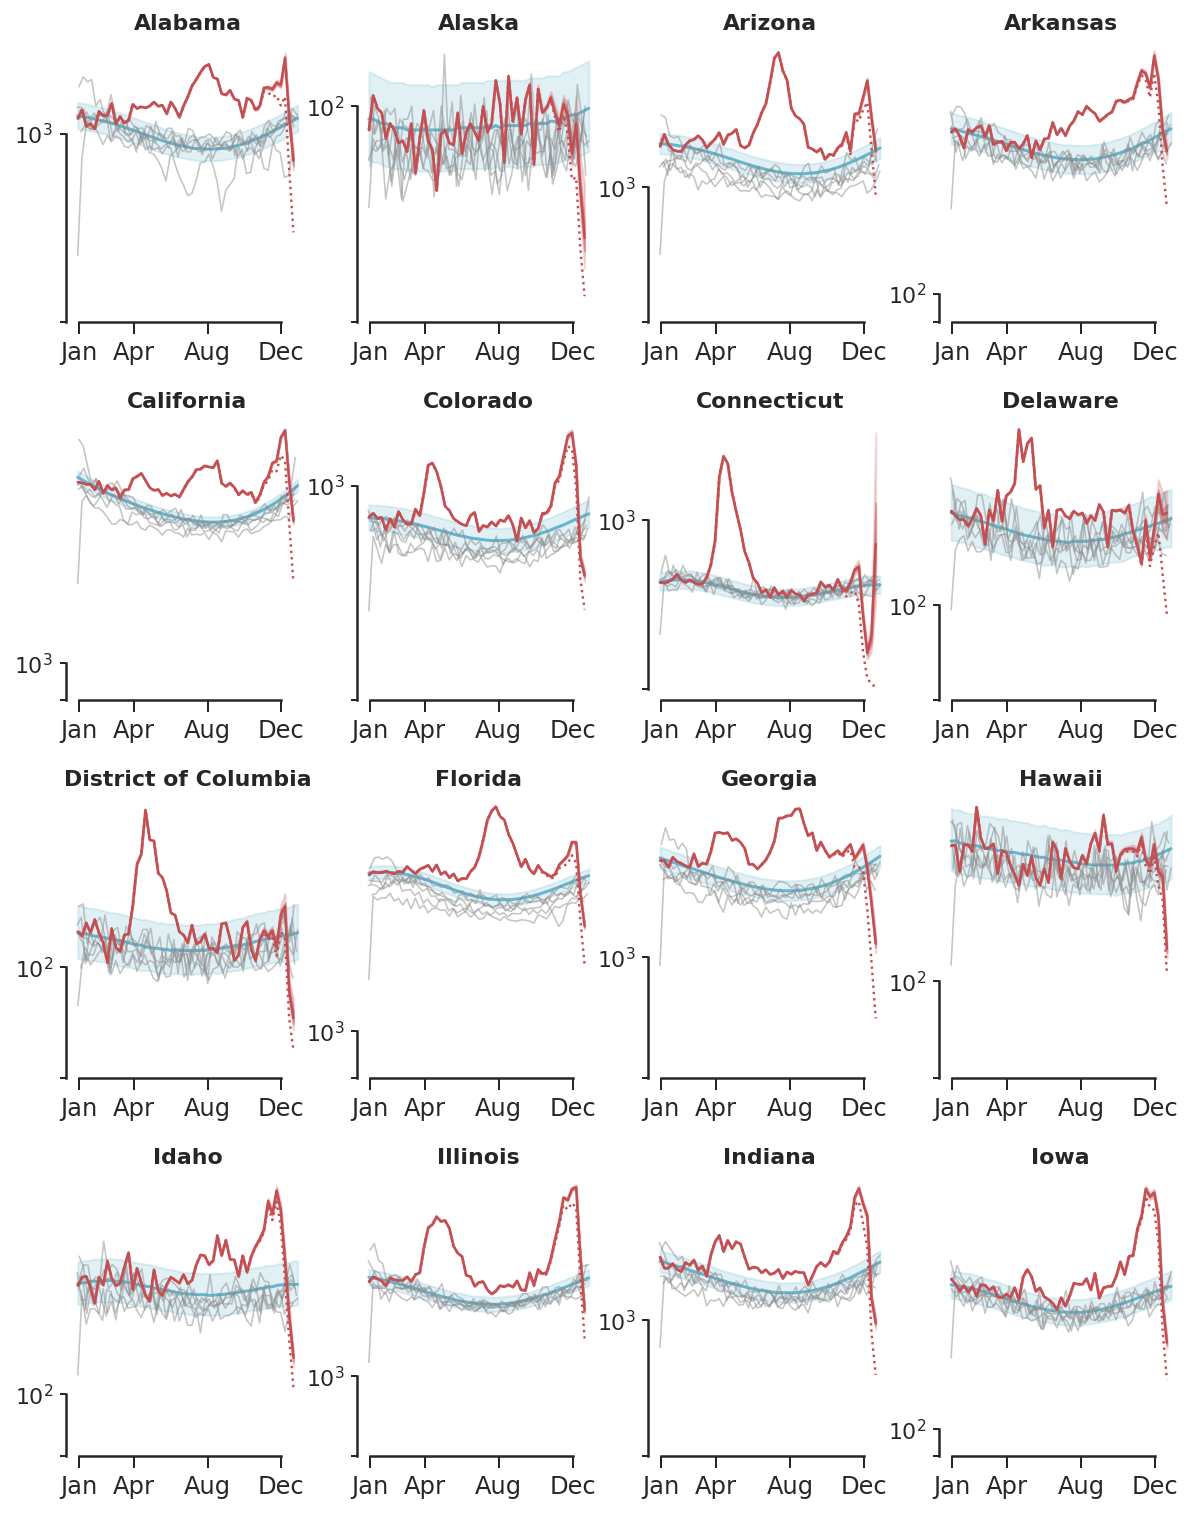

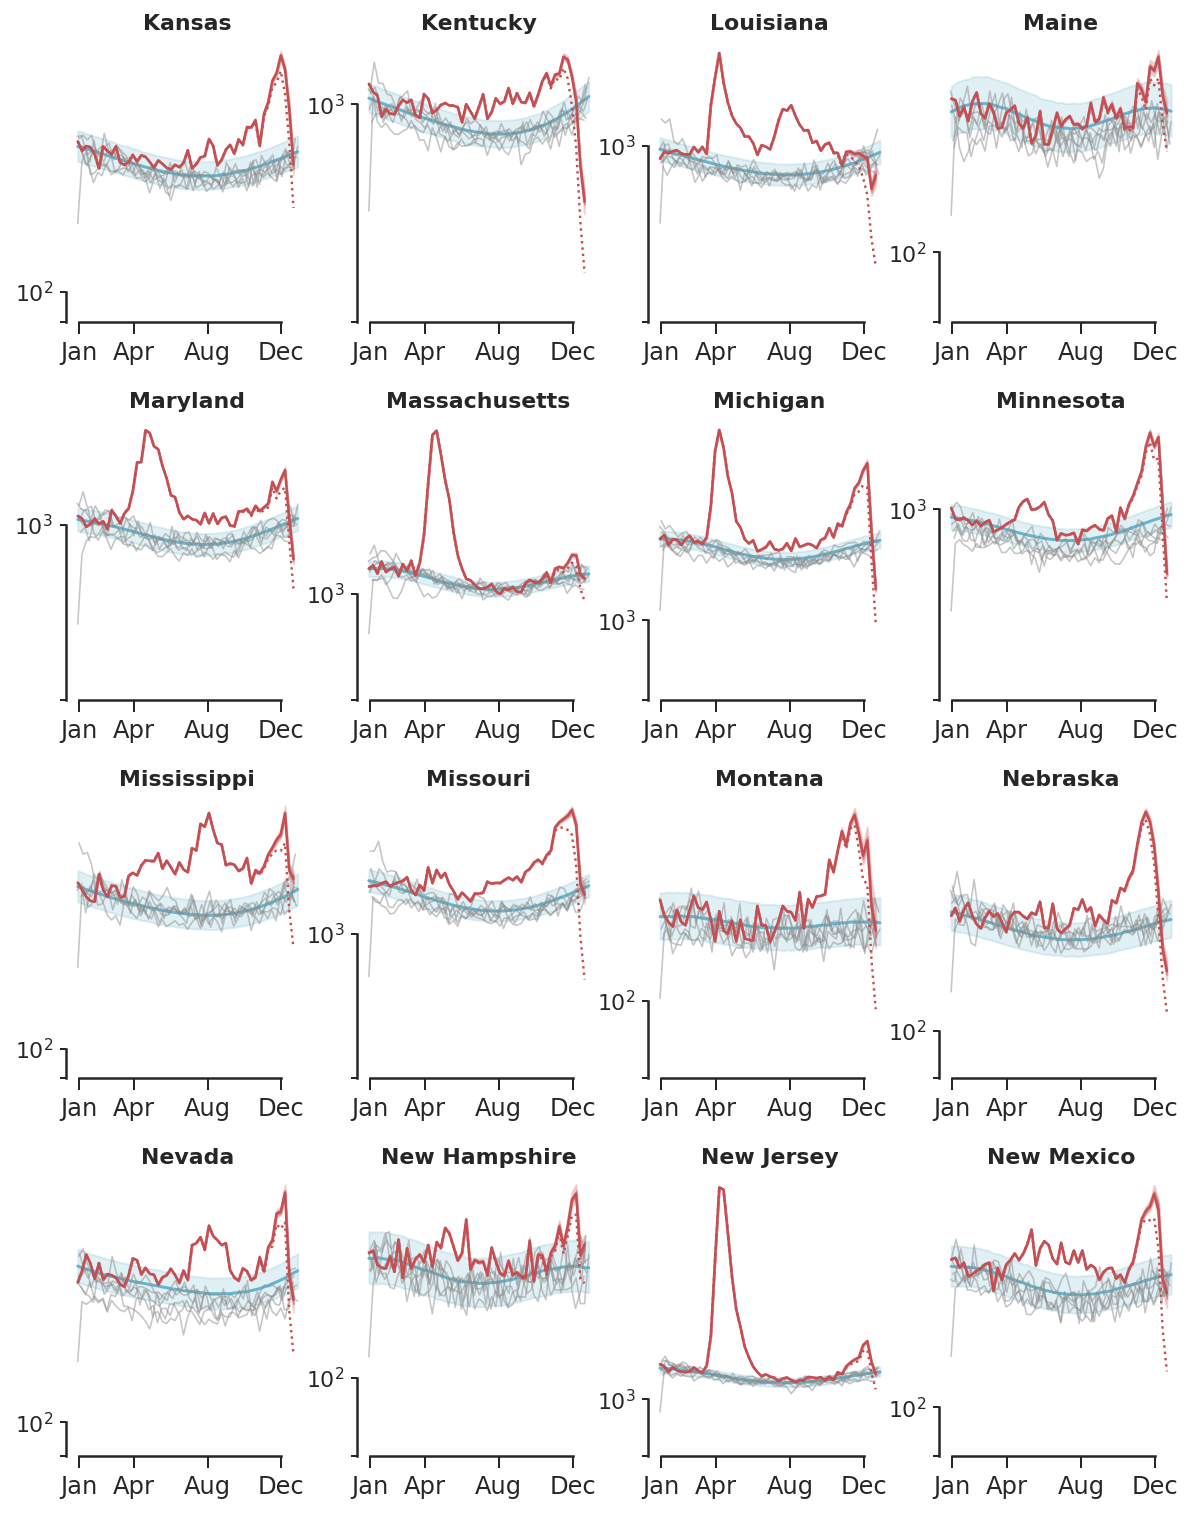

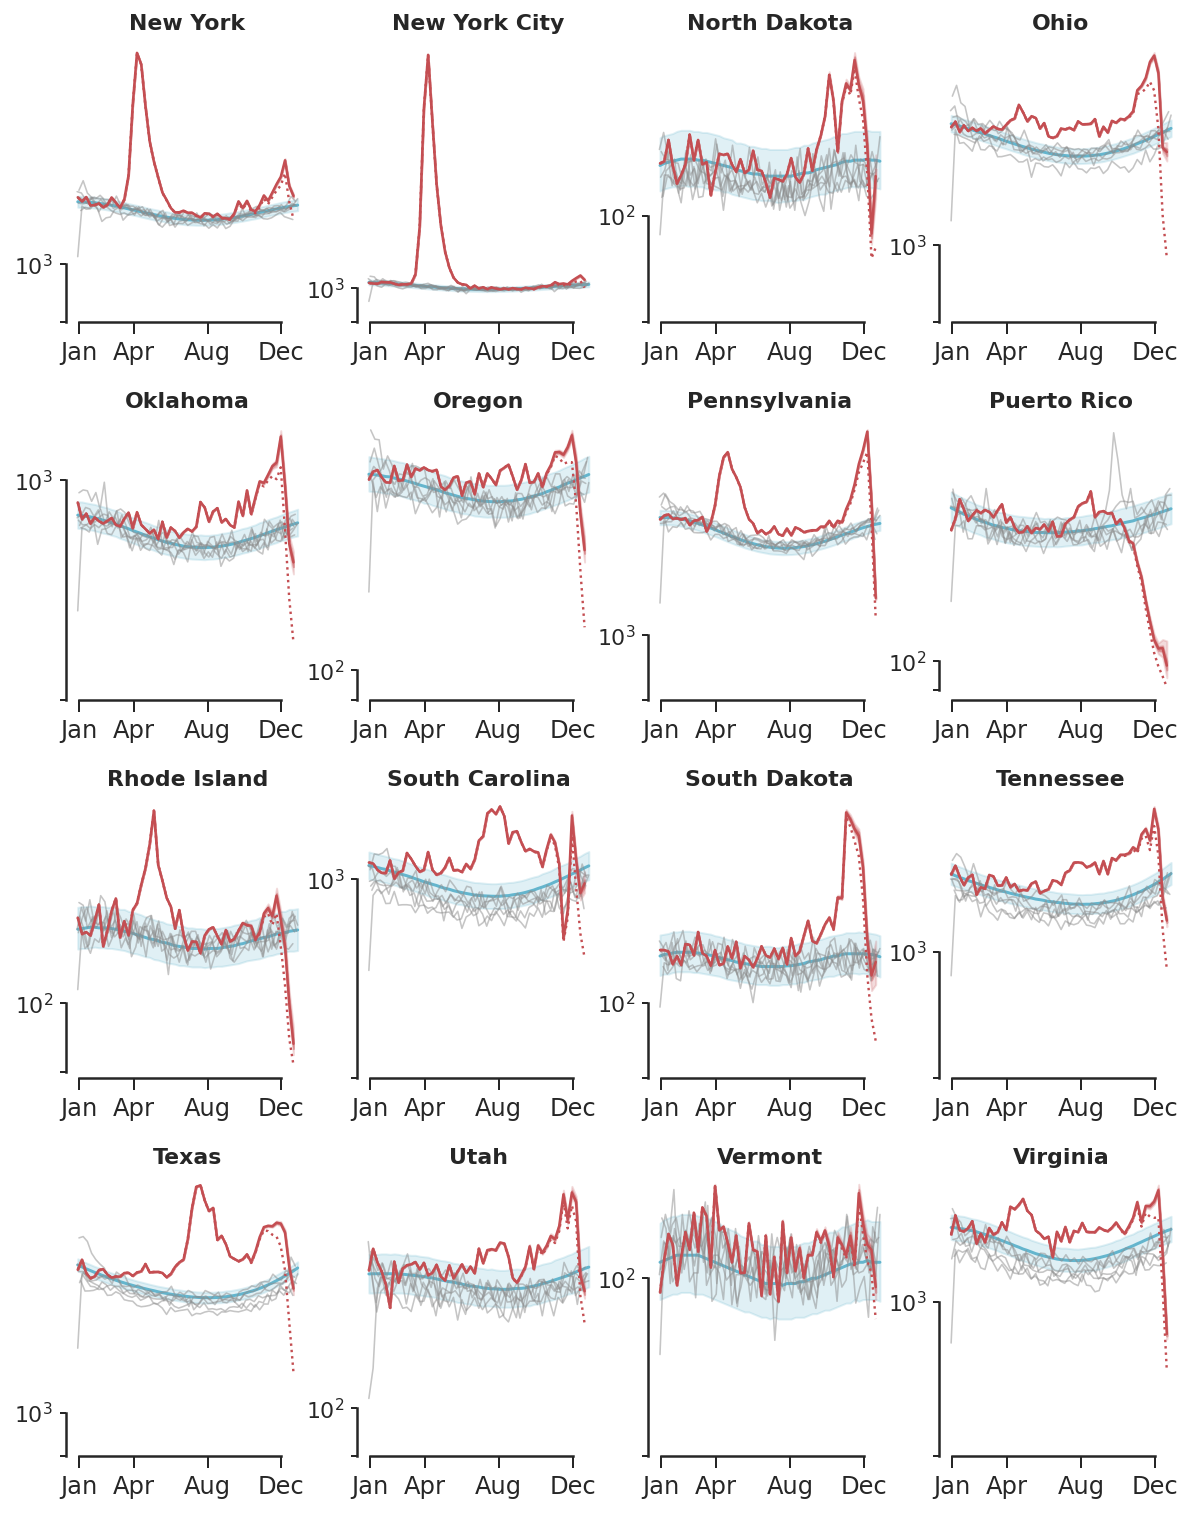

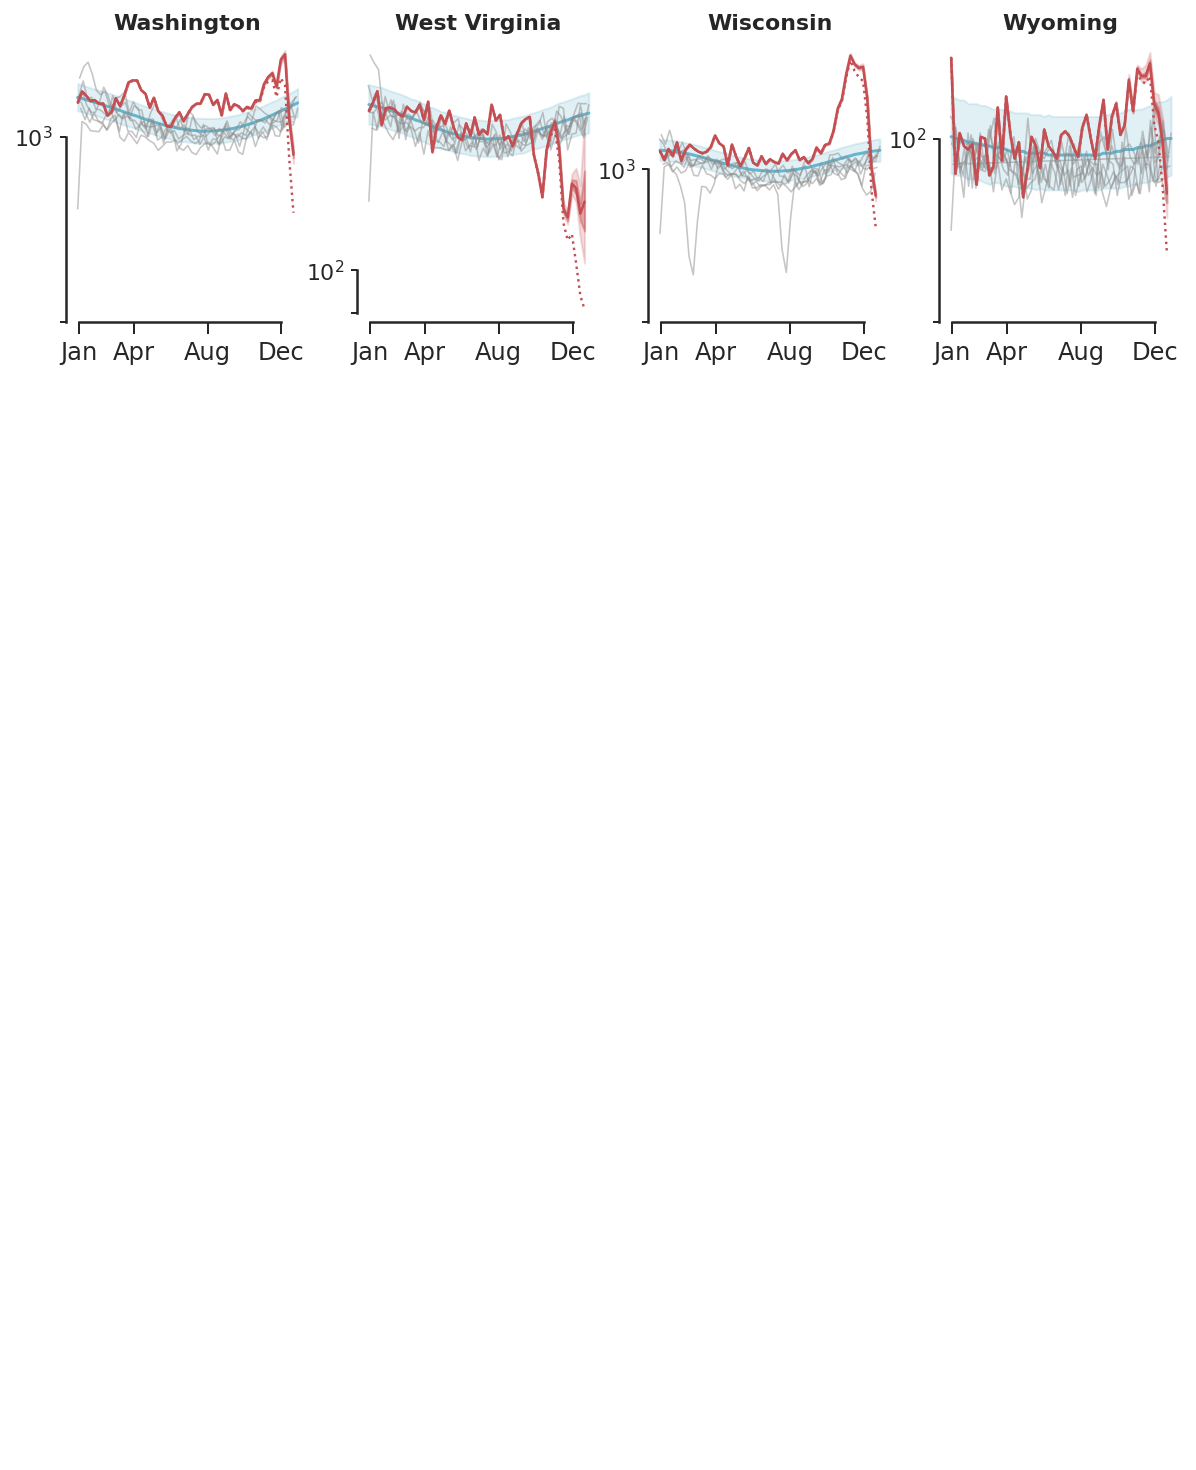

In [88]:
for j in range(4):
    fig, axs = plt.subplots(4, 4)
    fig.subplots_adjust(hspace=.35)
    fig.set_size_inches(10,13)

    for i in range(16):
        ax = axs[i // 4][i % 4]
        
        region = 16*j + i + 1
        
        if (region <= 52):
            # baseline deaths counts
            df_output_historical_ = df_output_historical.loc[lambda d: d.idx_jurisdiction == region]
            X = df_output_historical_['x_day']
            ax.fill_between(X, df_output_historical_['q2.5'], df_output_historical_['q97.5'], color='C9', 
                            zorder=-6.5, alpha=.2)
            ax.plot(X, df_output_historical_['median'], c='C9', linestyle='solid', lw=1.5, zorder=-6.5)
            
            
            # historical data for raw deaths counts 
            years = list(df_hist.year.unique())
            for year in years:
                df_hist_ = df_hist.loc[lambda d: (d.idx_jurisdiction == region)&(d['year']==year)]
                ax.plot(df_hist_['x_day'].values, list(df_hist_['number_of_deaths'].values), color='C7', alpha=.5, lw=.8)

            df_ = df_deaths_predicted.loc[lambda d: d.idx_jurisdiction == region]
            jurisdiction_ = df_.jurisdiction.values[0]
            X = df_['x_day']
            ytks_max_power = int(np.log10(max(df_['deaths'].values)))

            ax.plot(X, df_['deaths'], c='C3', linestyle='dotted', lw=1.2)
            ax.fill_between(X, df_['q2.5'], df_['q97.5'], color='C3', zorder=1.5, alpha=.2)
            ax.fill_between(X, df_['q25'], df_['q75'], color='C3', zorder=2, alpha=.4)
            ax.plot(X, df_['median'], color='C3', zorder=3, lw=1.25)

            #ax.set_xlabel('Week'); ax.set_ylabel('Deaths')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_bounds([0, 10**ytks_max_power])
            ax.spines['bottom'].set_bounds([min(xtks), max(xtks)])
            ytks = [0, 10**ytks_max_power]; ax.set_yticks(ytks); ax.set_yticklabels(["", "$10^%d$"%ytks_max_power])
            ax.tick_params(axis="y", length=3, labelsize=11)
            ax.set_xticks(xtks); ax.set_xticklabels(xtk_labels)
            ax.set_title(jurisdiction_, fontweight='bold', fontsize=11)
        else:
            ax.axis('off')
            
    #fig.savefig('../../figures/draft/FigS3_partial-%d.pdf'%(j+1), format="pdf", bbox_inches='tight')    